## **ABCDEats Company - Customer Segmentation**

![Alt Text](https://www.coforge.com/hubfs/Imported_Blog_Media/Screenshot-2022-01-20-at-12_18_26-1024x294-1-1.png)


**Notebook 3:  Data Preparation-Part 2**

We are now at stage 3: In this step of the Process, we will finish data preparation, we will identify and treat outliers, create and explore new features, and we will also perform feature reduction.

## **Group Members:**

* **Guilherme Goudinho**- 20211552
* **Maria Inês Assunção**- 20211605
* **Osmáiny Raimundo**- e20191506
* **Vinincius Lallo**- 20211682

<a id = "toc"></a>
## Table of Contents

1. [Imports](#Imports)
2. [Loading Our Dataset](#2-loading-our-dataset)
3. [Separating Our Data](#3-separating-our-data)
4. [Treating The Outliers](#4-treating-outliers)
5. [Feature Engineering](#5-feature-engineering)
6. [Feature Reduction](#6-feature-reduction)
7. [Feature Transformation](#7-feature-transformation)


## **1. Imports** <a id="Imports" class="anchor"></a>
[Back to ToC](#toc)<br>

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import chi2_contingency
import scipy.stats as stats


import os
from math import ceil
from itertools import product
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import PowerTransformer


#extras
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'  # For better resolution plots
sns.set()
pd.set_option('display.max_columns', None)  # To display all columns


In [2]:
# Auxiliary Function to Calculate bins for histograms based on Sturges' rule
def number_bins_sturges(data):
    '''
    Calculates the number of bins based on the number of data points, using Sturges' rule
    Sturges' rule: k = log2(n) + 1

    Requires: The dataset for which the number of bins is to be calculated.
    Ensures: 
        - The returned value is a positive integer representing the number of bins.
        - The number of bins increases logarithmically as the dataset size increases.
    '''
    
    n = len(data)
    bins = np.ceil(np.log2(n) + 1) # np.log2 computes the base-2 logarithm of n, and np.ceil rounds the result up to the next whole number.
    return int(bins)

#Defining the colors for our graphs
colors = {
    "R": "#F5979D", #light red
    "BL": "#0a9ea3", #cyan blue
    "BR": "#4F323D", #brown
    "B": "#9cc5d9",  #light blue
    "G": "#099c52",  #spring green
    "Y": "#d69231",   #Yellow
    "M": "#960b50",   # some kind of pink
    "P": "#6947ad" ,   # Purple
    "PR": "#ad474c"  #Weird red
}

def show_missing(data):
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    for item in data.columns:
        variables.append(item)
        dtypes.append(data[item].dtype)
        count.append(len(data[item]))
        unique.append(len(data[item].unique()))
        missing.append(data[item].isna().sum())
    output = pd.DataFrame({
    'variable': variables, 
    'dtype': dtypes,
    'count': count,
    'unique': unique,
    'missing': missing, 
    })
    return output

### **2. Loading our Dataset**

In [3]:
food_df=pd.read_csv("../Data/food_df_dataset.csv") # Importing our dataset into a variable "food_df" with imputed missing values

__**Setting our Index Column**__

In [4]:
food_df = food_df.set_index('customer_id')

__**Checking Data Types**__

In [5]:
food_df['customer_region'].dtype

dtype('int64')

> This is wrong, probably as a consequence of the data exporting, so we need to turn <code>customer_region</code> back into 'object'.

In [6]:
food_df['customer_region'] = food_df['customer_region'].astype('object') # fixed

> We imputed our <b>Missing Values</b> in the previous notebook and exported the dataset with these treated.
> - <code>customer_age</code>: Imputed with the mean. (After conducting analysis)
> - <code>first_order</code>: Imputed with '0' as these corresponded to customers whose first_order was on the same day as last_order (day 0).
> - <code>HR_0</code>: Imputed with the discrepancy between total_order by DOW and by HR.

In [7]:
columns_with_missing = food_df.isna().sum()[food_df.isna().sum() > 0].count()
print(f"There are {columns_with_missing} columns with more than 0 missing values.")

There are 0 columns with more than 0 missing values.


## **3. Separating Our Data**

> We will drop the following columns as they were previously engineered to be represented by aggregations, described in our EDA and initial preprocessing notebook (part 1).
> We will considered the aggregations for our analysis, since studying outliers in them will necessarily give us insights into the individual divisions. 
> - For example, <code>DOW_[0-6]</code> into 'Weekday' or 'Weekend. 
> - <code>CUI's</code> into Asian, Western, Desserts_Beverages, Healthy, OTHER, streetfood/snacks.

In [8]:
columns_to_drop = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 
                   'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 
                   'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 
                   'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 
                   'HR_22', 'HR_23',
                   'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 
                   'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 
                   'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 
                   'CUI_Thai']
food_df = food_df.drop(columns=columns_to_drop)
show_missing(food_df)

,variable,dtype,count,unique,missing
0,customer_region,object,31737,3,0
1,customer_age,int64,31737,66,0
2,vendor_count,int64,31737,36,0
3,product_count,int64,31737,92,0
4,is_chain,int64,31737,60,0
5,first_order,int64,31737,91,0
6,last_order,int64,31737,91,0
7,last_promo,object,31737,4,0
8,payment_method,object,31737,3,0
9,CUI_Healthy,float64,31737,1285,0


> After conducting our analysis on the box plots for each of our numerical variables, we concluded that our one-time customers were probably creating a bias in our data. <br>
> For this reason, we decided to separate this type of customer and perform a separate analysis. The rest of our data will represent the behavior of the customers we are trying to segment.<br>
> We believe this will highly influence our outlier percentages, lowering them and allow us to retain as much information as possible. <br>

> This notebook will address the <b>Remaining Customers</b>.

In [9]:
one_time_customers_df = food_df[food_df['total_orders'] == 1]
food_df = food_df[food_df['total_orders'] > 1]
print(f"One-time customers: {one_time_customers_df.shape[0]} records")
print(f"Remaining customers: {food_df.shape[0]} records")

One-time customers: 6908 records
Remaining customers: 24829 records


> We identified <b>24829</b> records where we might be able to identify patterns/trends in our customers behavior. <br>
> These represent roughly <b>78%</b> of our data. <br>

In [10]:
food_df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'total_orders',
       'midday_orders', 'evening_orders', 'late_night_orders', 'Weekend',
       'Weekday', 'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages',
       'total_spent'],
      dtype='object')

__**Reorganizing Columns**__

In [11]:
column_order = ['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages',
       'CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks', 
       'midday_orders', 'evening_orders', 'late_night_orders', 'Weekend', 'Weekday',
       'total_orders', 'total_spent']
food_df = food_df[column_order]

## **Remaining Customers**

In [12]:
show_missing(food_df)

,variable,dtype,count,unique,missing
0,customer_region,object,24829,3,0
1,customer_age,int64,24829,65,0
2,vendor_count,int64,24829,36,0
3,product_count,int64,24829,91,0
4,is_chain,int64,24829,60,0
5,first_order,int64,24829,90,0
6,last_order,int64,24829,91,0
7,last_promo,object,24829,4,0
8,payment_method,object,24829,3,0
9,Western_Cuisine,float64,24829,4668,0


__**Data Statistics for Remaining Customers**__

In [13]:
food_df.describe().round(2)

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,Western_Cuisine,Asian_Cuisine,Desserts_Beverages,CUI_Healthy,CUI_OTHER,CUI_Street Food / Snacks,midday_orders,evening_orders,late_night_orders,Weekend,Weekday,total_orders,total_spent
count,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00,24829.00
mean,27.52,3.70,6.89,3.45,23.35,68.65,10.62,20.76,4.71,1.15,3.60,4.37,2.35,2.22,1.04,2.46,2.87,5.33,45.22
std,7.07,2.87,7.43,4.29,20.82,19.53,18.91,32.76,13.22,6.50,10.82,16.93,3.25,3.19,3.06,2.69,3.41,5.39,50.13
min,15.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.78
25%,23.00,2.00,3.00,1.00,6.00,58.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,2.00,17.54
50%,26.00,3.00,4.00,2.00,18.00,75.00,4.18,11.49,0.00,0.00,0.00,0.00,2.00,1.00,0.00,2.00,2.00,4.00,30.09
75%,31.00,4.00,8.00,4.00,36.00,84.00,13.32,26.18,3.51,0.00,1.46,0.00,3.00,3.00,1.00,3.00,3.00,6.00,54.77
max,80.00,41.00,269.00,83.00,89.00,90.00,468.33,1201.27,326.10,255.81,366.08,454.45,71.00,61.00,81.00,45.00,60.00,94.00,1418.33


> - The average <code>customer_age</code> is still 27y.
> - On average, people buy from 3.12 different vendors.
> - Each customer, on average, makes 4.39 orders and 5.69 products.
> - 50% of customers made their <code>first_order</code> within the first month and their <code>last_order</code> within the third.
> - Amounts spent by <code>CUI Aggregations</code> differ a lot, from 0.95€ to 17.65€.
> - Customers spent the most on <code>Asian_Cuisine</code> followed by <code>Western_Cuisine</code>, with 17.65€ and 8.92€ respectively.
> - There are more orders during the midday or the evening. Also, on average, more orders are placed during the week.
> - On average, customers spend 38.46€ ordering food. The max for <code>total_spent</code> is 1418.33€ which is surprising.

## **4. Treating Outliers**

> In this section, we will discuss the most appropriate outlier treatment for each column.

In [14]:
num_columns = food_df.select_dtypes(include=['int64', 'float64']).columns # numerical variables
cat_columns = food_df.select_dtypes(include=['object', 'O']).columns # categorical variables

__**Calculating the Percentage of Outliers per Column**__ (Inter-Quartile Range Formula)

$IQR = Q_3 – Q_1$

<br>

---

<br>

**Outliers** are the observations that fall:
- below $Q_1 − 1.5 \times IQR$

or

- above $Q_3 + 1.5 \times IQR$

<br>

In [15]:
outlier_percentages = {}

# We know that low outliers are below Q 1 − 1.5 ⋅ IQR ‍ and high outliers are above Q 3 + 1.5 ⋅ IQR 
for column in num_columns:
        #Defining Q1 and Q3 to then find IQR 
        Q1 = food_df[column].quantile(0.25)
        Q3 = food_df[column].quantile(0.75)
        IQR = Q3 - Q1
        #Getting the outliers below the first quantile and above the second quantile
        outliers = food_df[(food_df[column] < (Q1 - 1.5 * IQR)) | (food_df[column] > (Q3 + 1.5 * IQR))]
        #Getting the percentage of the outliers
        percentage_outliers = (len(outliers) / len(food_df)) * 100
        outlier_percentages[column] = percentage_outliers

#Printing the results and counting the number of columns per the percentage higher or lower than 5.
nr_col_lower_5=0
nr_col_higher_5=0
print("Percentage of outliers per column using IQR:")
for column, percentage in outlier_percentages.items():
    print(f"{column}: \033[1;35m{percentage:.2f}%\033[0m")
    if percentage <5:
        nr_col_lower_5+=1
    if percentage >5:
        nr_col_higher_5+=1

#Printing the number of columns who have a percentage lower than 5% and then higher than 5%. 
# We chose 5% because it was the percentage advised during classes
print(f"From the columns, \033[1;33m{nr_col_lower_5}\033[0m have a percentage lower than 5%")
print(f"From the columns, \033[1;33m{nr_col_higher_5}\033[0m have a percentage higher than 5%")

Percentage of outliers per column using IQR:
customer_age: 3.40%
vendor_count: 8.53%
product_count: 8.35%
is_chain: 7.95%
first_order: 0.79%
last_order: 2.36%
Western_Cuisine: 7.86%
Asian_Cuisine: 6.89%
Desserts_Beverages: 15.87%
CUI_Healthy: 8.16%
CUI_OTHER: 21.29%
CUI_Street Food / Snacks: 14.70%
midday_orders: 7.24%
evening_orders: 5.47%
late_night_orders: 11.26%
Weekend: 6.24%
Weekday: 9.28%
total_orders: 7.27%
total_spent: 7.54%
From the columns, 3 have a percentage lower than 5%
From the columns, 16 have a percentage higher than 5%


> - We decided to consider a <b>threshold of 5%</b>, where outliers with a percentage lower than 5% will be completly removed. Meaning we will save them to a variable and decide how to analyse them later. <br>
> - Outliers above 5%, we will get the extreme outliers by a handmade function and winsorize the rest of them to the upper limit.<br>
> - Outliers in the CUI columns will not be removed because they are represent relevant data. We believe that because there are so many types of cuisines, the ones that are less popular will have a lot of '0' values and this is causing the real data to look like outliers.

__**Ploting Box Plots**__

In [16]:
CUI_features = ['CUI_Healthy', 'CUI_OTHER','CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']

In [17]:
num_columns_without_CUI = num_columns.tolist()

In [18]:
for feature in CUI_features:
    num_columns_without_CUI.remove(feature)

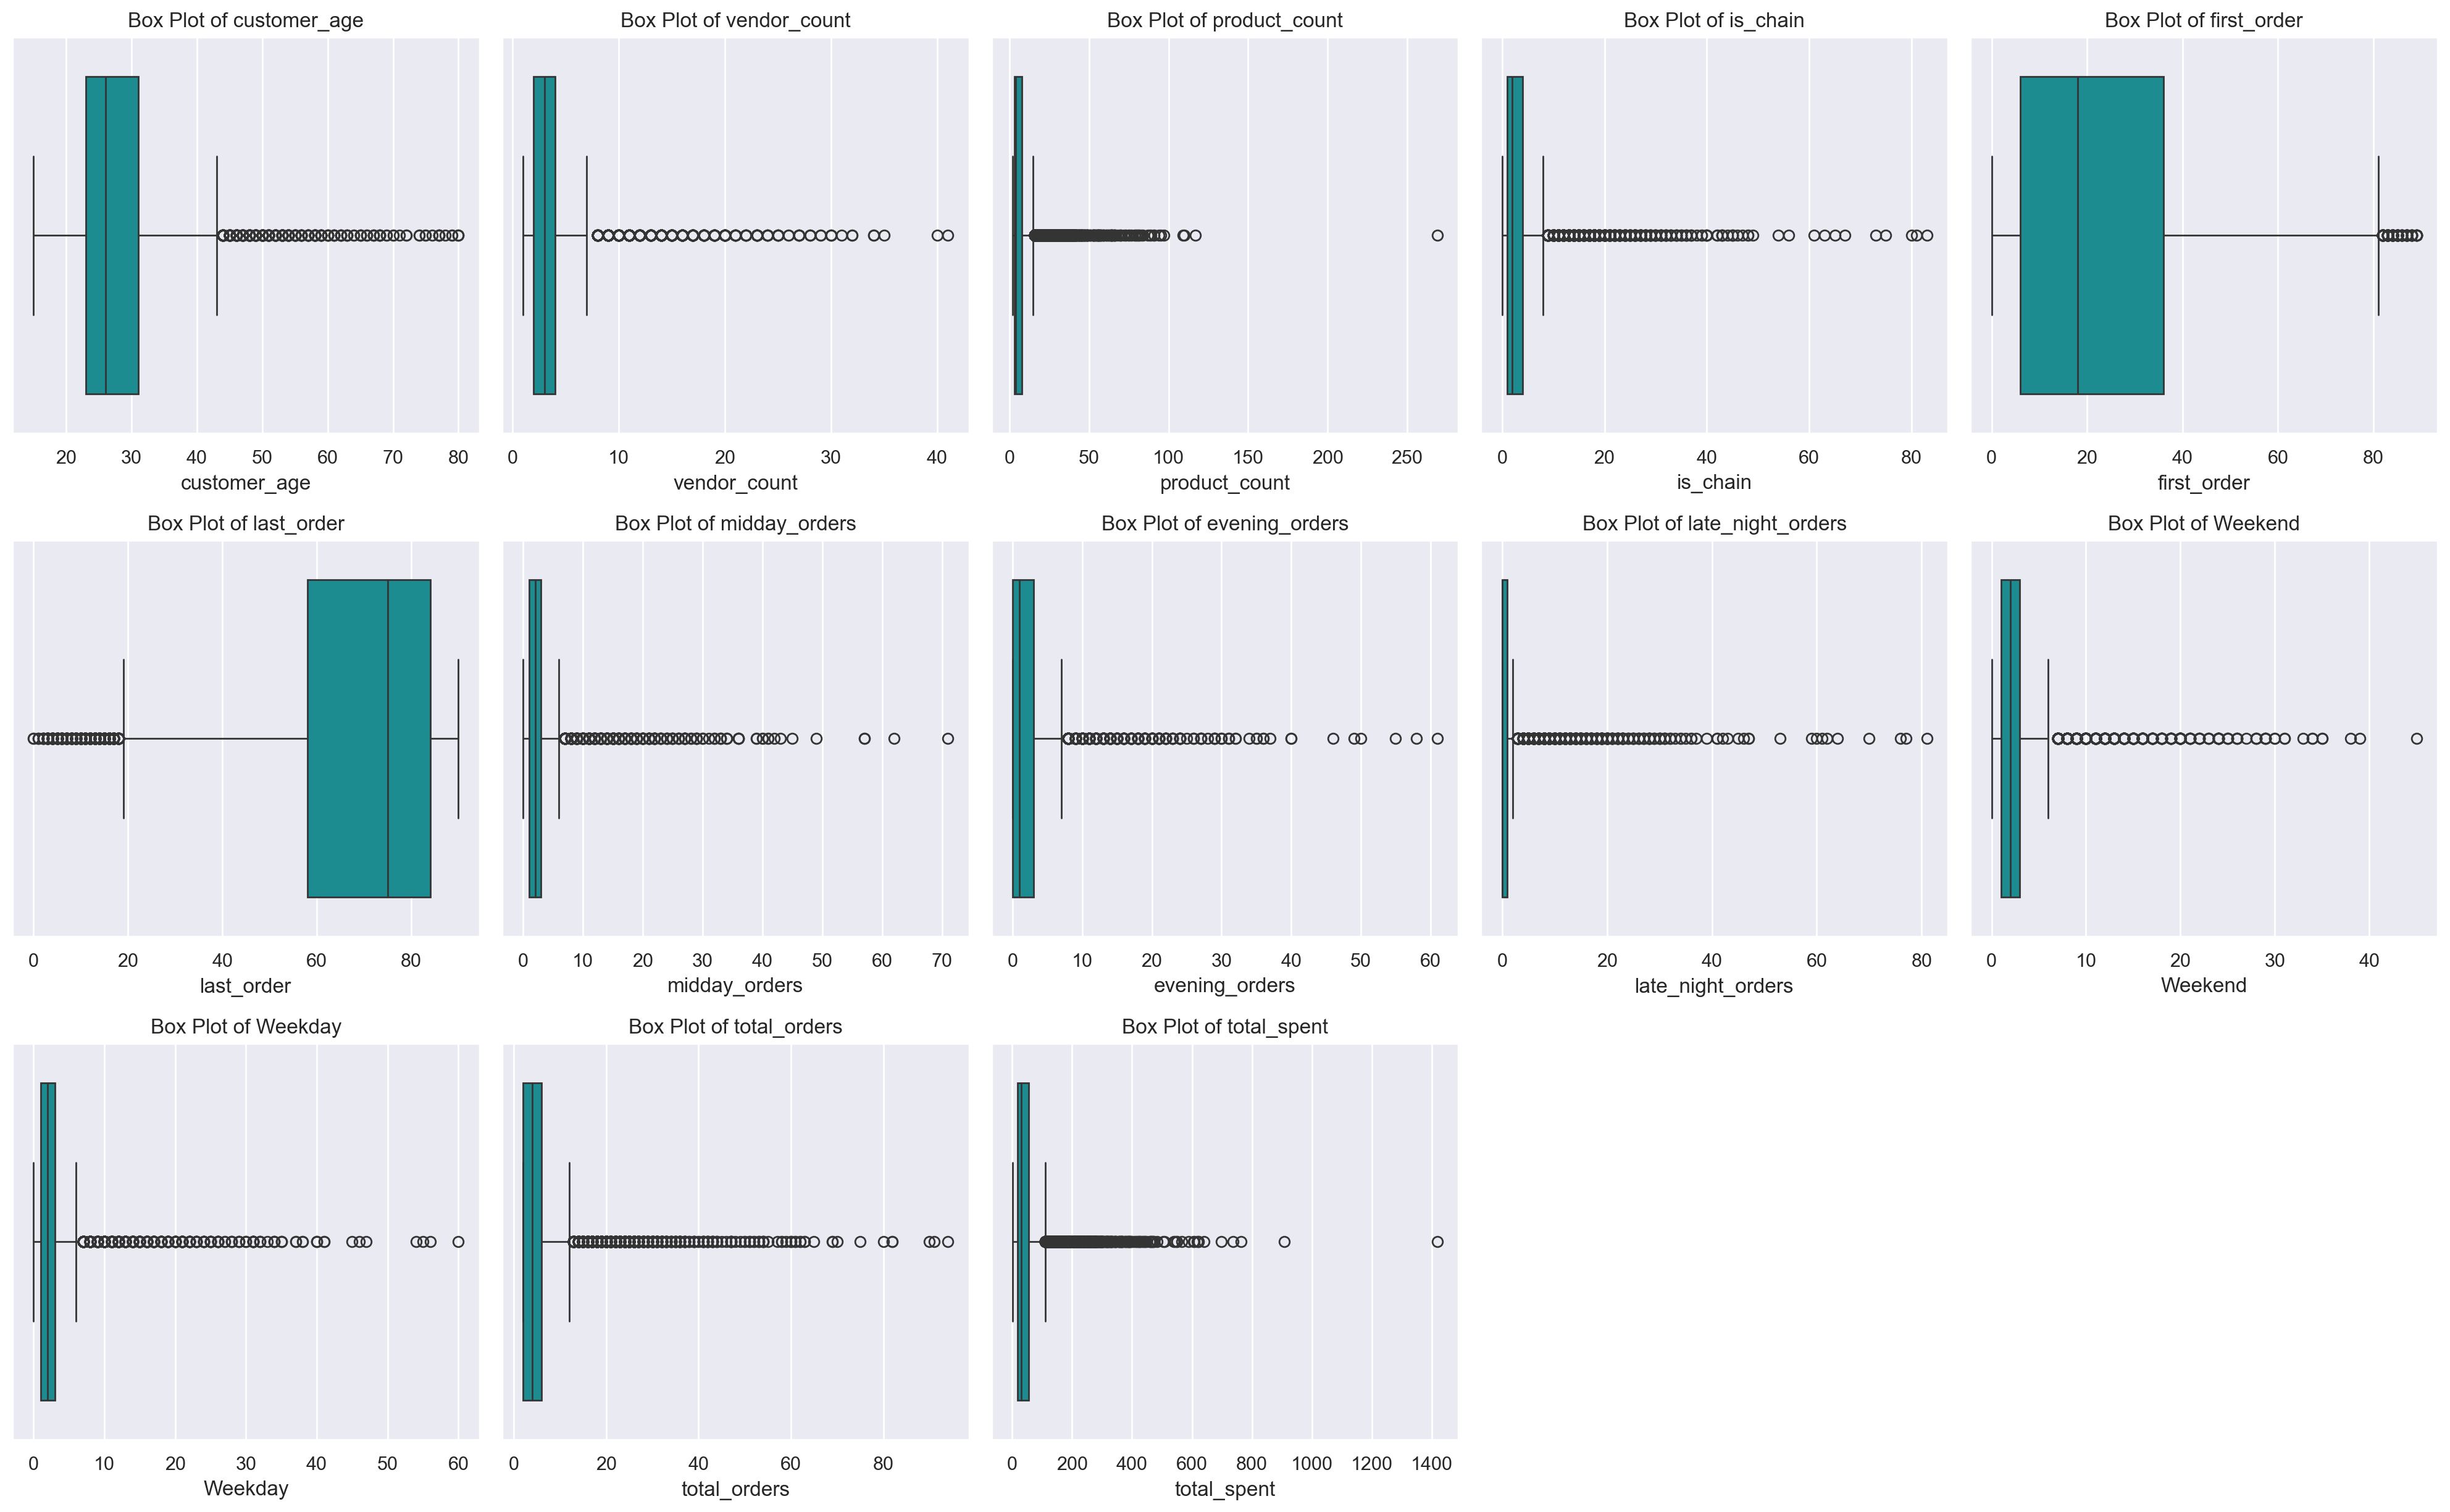

In [19]:
n_cols = 5
n_rows = 4  # Calculate rows needed

# Set the figure size for readability
plt.figure(figsize=(20, 4 * n_rows))

# Plot each numerical column in a separate horizontal box plot
for i, column in enumerate(num_columns_without_CUI, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=food_df, x=column, color = colors['BL'])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

In [20]:
# Function to automate outlier removal by the Interquartile Range
lower_limit = 0
upper_limit = 0
def outlier_removal_helper(dataframe, feature, lower_limit=lower_limit, upper_limit = upper_limit):
    # Mask to filter values within the IQR range
    mask = dataframe[feature].between(lower_limit, upper_limit, inclusive="both")
     
    return dataframe[mask]

# Function to automate lower and upper bound detection in a feature to facilitate plotting box plots
def boxplt_info(feature,dataframe=food_df):
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    return lower_limit, ceil(upper_limit)

# Auxiliary function to check the percetnage of data kept
def outliers_left(df1, df2):
    return print (f" The percentage of data kept is: {round((len(df1) / len(df2) ) * 100,2)}")

__**Checking Features with <5% Outliers**__

> This section will work as follows:
> - Select feature, <i>'feature_name'</i> (that have outliers <5%)
> - Plot boxplot
> - Calculate upper and lower limits (save values)
> - Saving outliers into a variable <i>'out_feature_name'</i>
> - Checking the describe of that variable to identify trends or patterns
> - Removing the outliers from the auxiliary dataset <b>'food_df_out'</b>
> - Print percentage of data left (checking how much information we keep)<br>

> At the end we will plot all boxplots again (to check if outliers were dropped sucessfully) and the total percentage of data left, to check if we are not losing relevant information.

In [21]:
food_df_out = food_df.copy() # creating a copy of our data set to facilitate pipeline

    customer_age

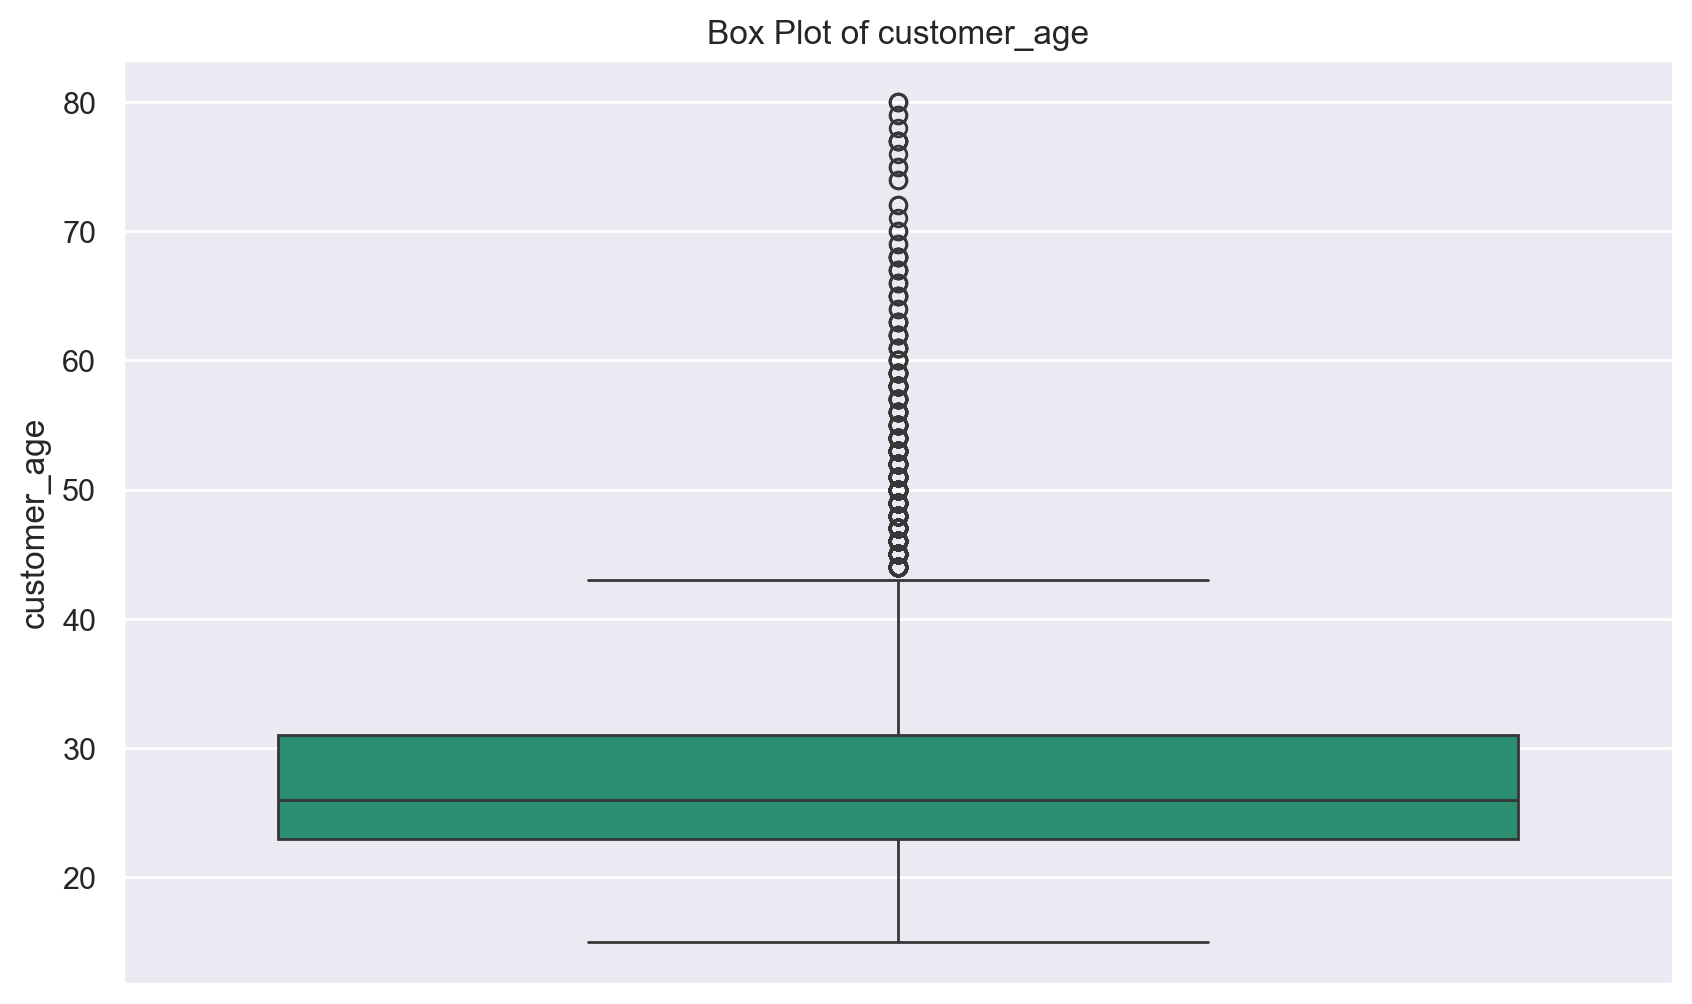

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df, y='customer_age', palette='Dark2')
plt.title('Box Plot of customer_age')
plt.ylabel('customer_age')
plt.show()

In [23]:
lower_limit, upper_limit = boxplt_info('customer_age')
print(f" The lower limit is {lower_limit}, and the upper limit is {upper_limit}")

 The lower limit is 11.0, and the upper limit is 43


In [24]:
out_customer_age = food_df[food_df['customer_age'] > upper_limit] # saving outliers
out_customer_age['customer_age'].describe(include=all).round(2)

count    845.00
mean      50.05
std        6.66
min       44.00
25%       45.00
50%       48.00
75%       53.00
max       80.00
Name: customer_age, dtype: float64

> - The were 845 outliers identified.
> - The average value of the outliers removed is 50.05.
> - 50% of the outliers are below the value 48.
> - The lowest outlier has value 44 and the highest has value 80.

> However, because we have checked before that <code>customer_age</code> isn't correlated with any other variable, we will probably end up dropping it. <br>
> For this reason, we have decided not to remove any outliers.

In [25]:
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 100.0


    first_order

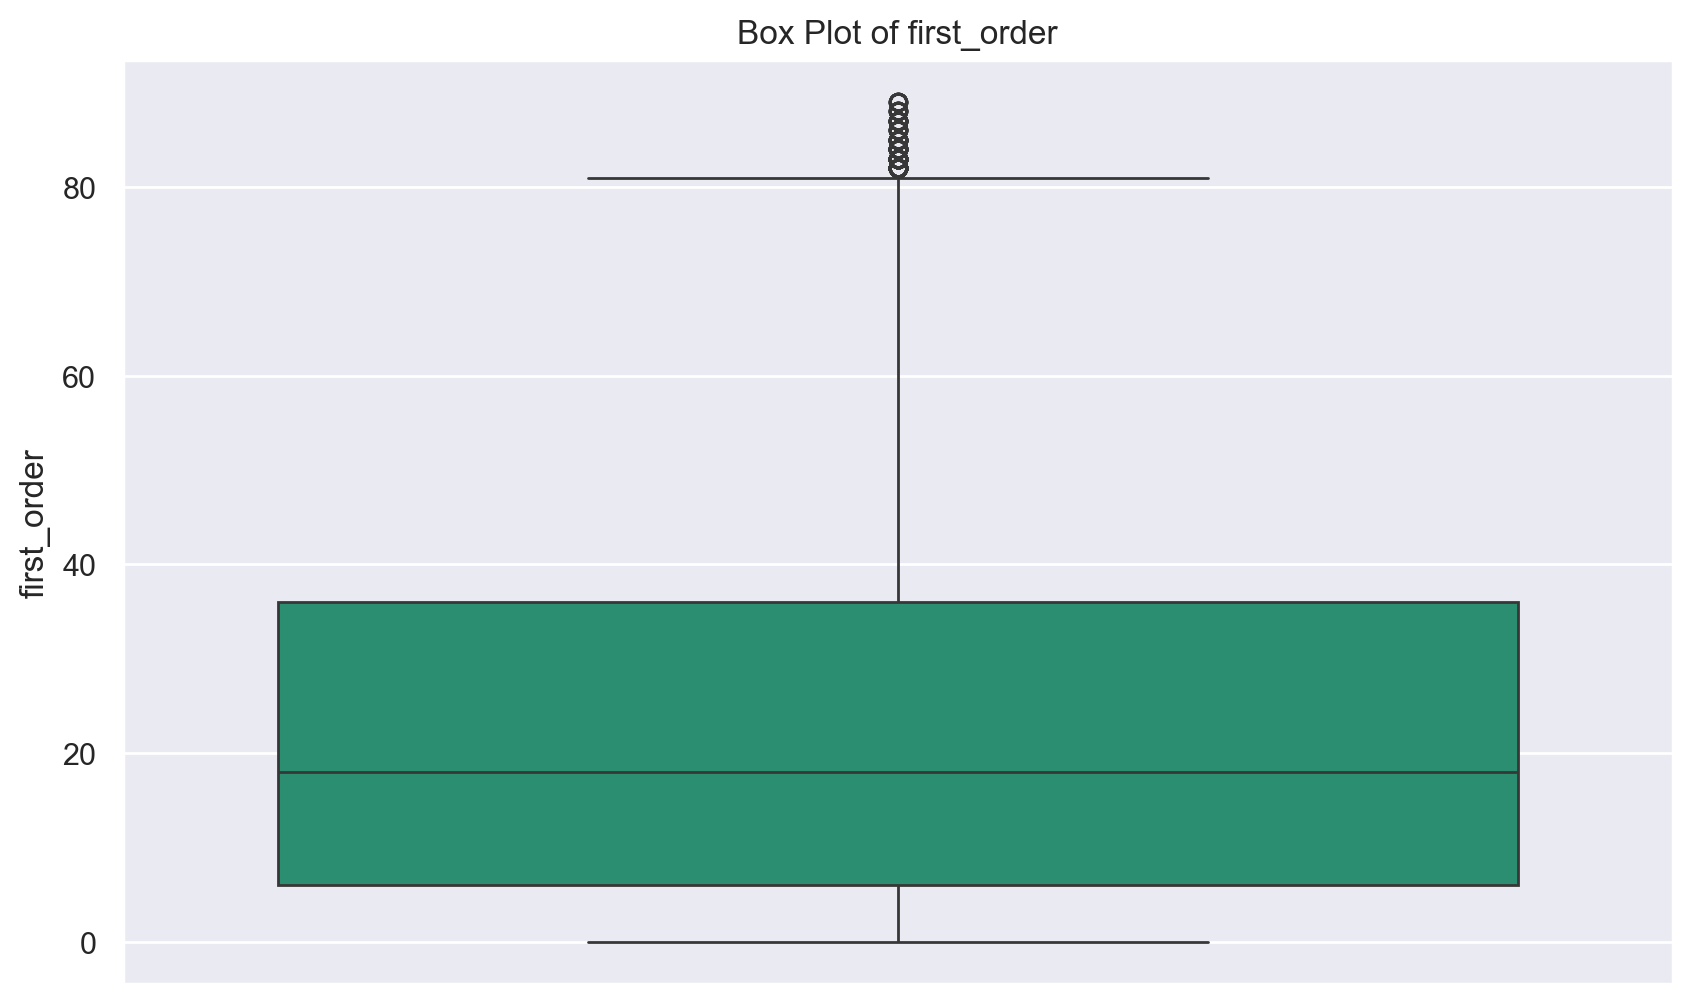

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='first_order', palette='Dark2')
plt.title('Box Plot of first_order')
plt.ylabel('first_order')
plt.show()

In [27]:
lower_limit, upper_limit= boxplt_info('first_order')
print(f" The lower limit is {lower_limit}, and the upper limit is {upper_limit}")

 The lower limit is -39.0, and the upper limit is 81


In [28]:
out_first_order = food_df[food_df['first_order'] > upper_limit] # saving outliers
out_first_order['first_order'].describe().round(2)

count    196.00
mean      84.09
std        2.05
min       82.00
25%       82.00
50%       83.00
75%       85.00
max       89.00
Name: first_order, dtype: float64

> - The were 196 outliers identified.
> - The average value of the outliers removed is 84.09.
> - 50% of the outliers are below the value 83.
> - The lowest outlier has value 82 and the highest has value 89.

In [29]:
food_df_out = outlier_removal_helper(food_df_out,'first_order', lower_limit, upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 99.21


    last_order

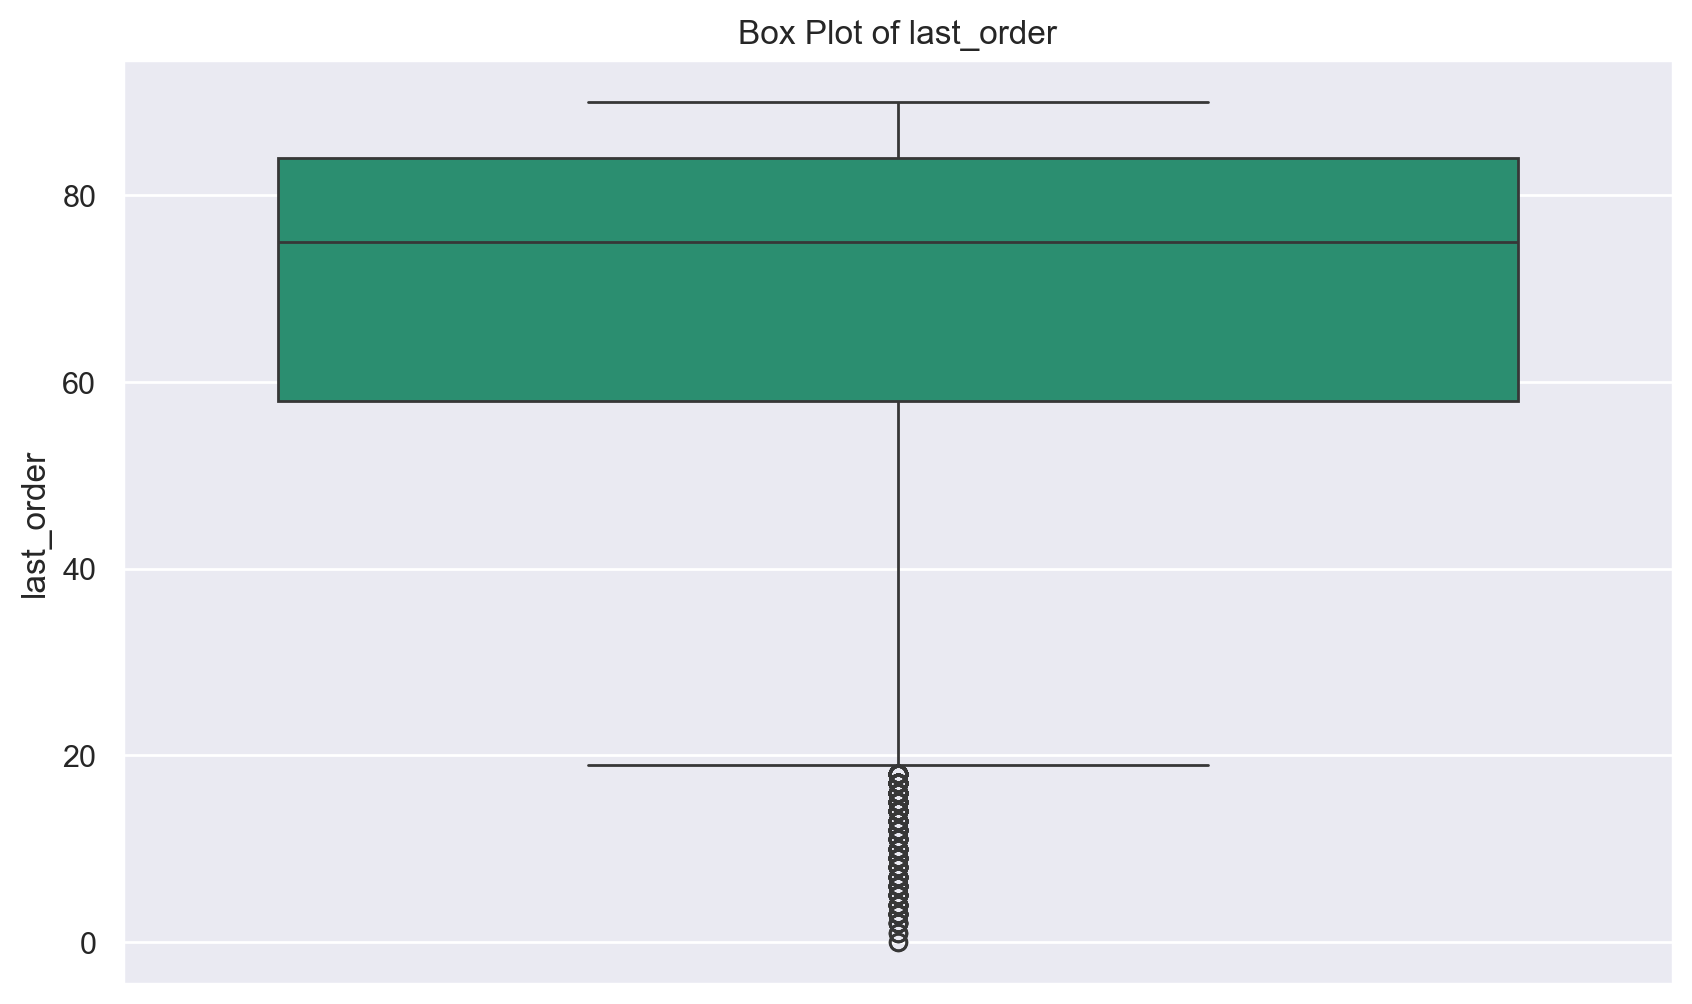

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='last_order', palette='Dark2')
plt.title('Box Plot of last_order')
plt.ylabel('last_order')
plt.show()

In [31]:
lower_limit, upper_limit= boxplt_info('last_order')
print(f" The lower limit is {lower_limit}, and the upper limit is {upper_limit}")

 The lower limit is 19.0, and the upper limit is 123


In [32]:
out_last_order = food_df[food_df['last_order'] < lower_limit] # saving outliers
out_last_order['last_order'].describe().round(2)

count    587.00
mean      11.85
std        4.67
min        0.00
25%        8.00
50%       13.00
75%       16.00
max       18.00
Name: last_order, dtype: float64

> - The were 587 outliers identified.
> - The average value of the outliers removed is 11.85.
> - 50% of the outliers are below the value 13.
> - The lowest outlier has value 0 and the highest has value 18.

In [33]:
print(f"The dataset had {out_last_order.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['last_order'] < lower_limit].shape[0]} outliers left.")

The dataset had 587 outliers.
Considering previous iterations, there are only 587 outliers left.


In [34]:
food_df_out = outlier_removal_helper(food_df_out,'last_order', lower_limit, upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 96.85


__**Checking Features with Outliers Between 5%-10%**__

> This section will work as the previous one, except:
> - We want to preserve as much information as possible, so we will use visual tools and manual outlier detection techniques to make our decisions.
> - We will use the IQR Formula with limits times 3 (instead of 1.5), this will increase our range and allow us to identify extreme outliers, guiding our approach.

In [35]:
extreme_lower_limit = 0
extreme_upper_limit = 0
# Function to help remove extreme outliers 
def extreme_outliers_removal(dataframe, feature,extreme_lower_limit= extreme_lower_limit, extreme_upper_limit=extreme_upper_limit):
    
    # Mask to filter values within the IQR range
    dataframe = dataframe[(dataframe[feature] >= extreme_lower_limit) & (dataframe[feature] <= extreme_upper_limit)]

    return dataframe

In [36]:
# Function to get the extreme upper and lower bounds
def boxplt_info_eo(feature, dataframe=food_df):
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    extreme_lower_limit = Q1 - 3 * IQR
    extreme_upper_limit = Q3 + 3 * IQR

    return extreme_lower_limit, ceil(extreme_upper_limit)

    is_chain

> At this point, we have decided not to treat the outliers for <code>is_chain</code> as we want to categorize this feature and transform it into a categorical variable with the percentages of orders made in chain restaurants. <br>
> We believe this categorization will provide us valuable insights into our customers behavior.

    vendor_count

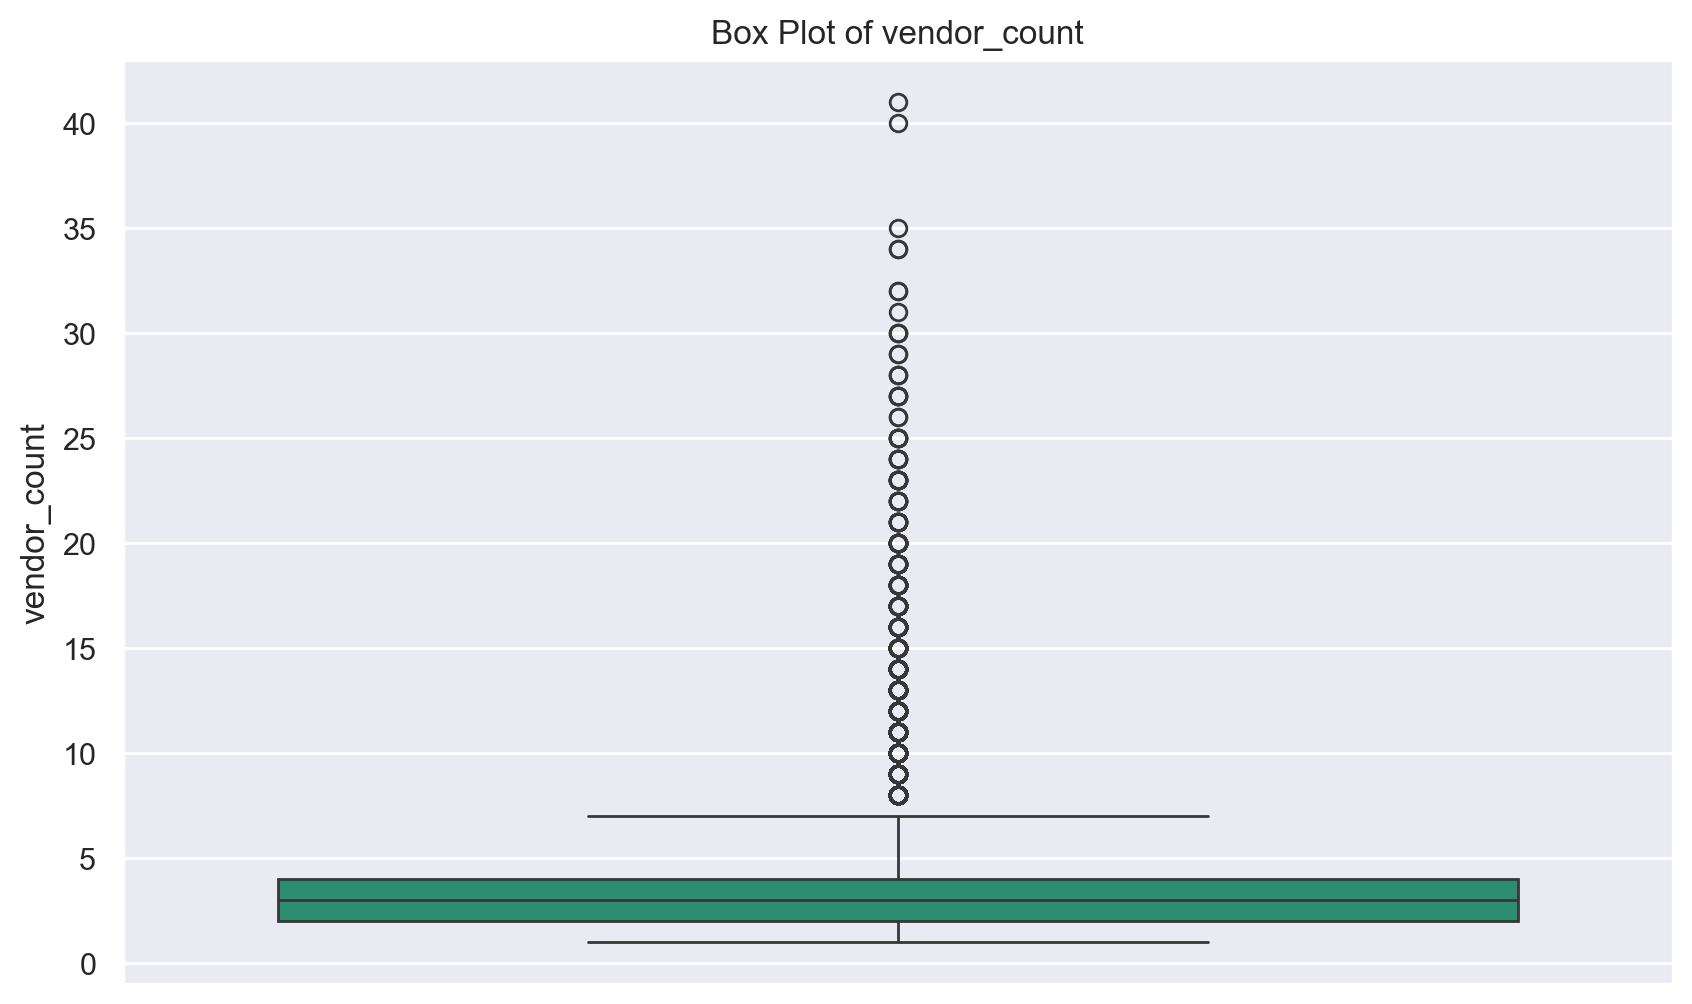

In [37]:
# plotting the graph with some of the outliers already removed for simplicity purposes
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='vendor_count', palette='Dark2')
plt.title('Box Plot of vendor_count')
plt.ylabel('vendor_count')
plt.show()

In [38]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('vendor_count')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -4.0, and the upper limit is 10


In [39]:
out_vendor_count = food_df[food_df['vendor_count'] > extreme_upper_limit] # saving outliers
out_vendor_count['vendor_count'].describe().round(2)

count    842.00
mean      14.30
std        4.16
min       11.00
25%       11.00
50%       13.00
75%       15.00
max       41.00
Name: vendor_count, dtype: float64

> - The were 842 extreme outliers identified.
> - The average value of the outliers identified is 14.3.
> - 50% of the outliers are below the value 1331.
> - The lowest outlier has value 11 and the highest has value 41.

In [40]:
print(f"The dataset had {out_vendor_count.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['vendor_count'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 842 outliers.
Considering previous iterations, there are only 842 outliers left.


In [41]:
food_df_out = extreme_outliers_removal(food_df_out, 'vendor_count', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 93.46


__**Winsorization of values**__

In [42]:
lower_limit, upper_limit = boxplt_info('vendor_count')
print(f"There are still {food_df_out[food_df_out['vendor_count'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 1273 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [43]:
food_df_out['vendor_count'] = np.clip(food_df_out['vendor_count'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of vendor count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['vendor_count'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    product_count

> From our EDA analysis, we see that both <code>product_count</code> and <code>vendor_count</code> are highly correlated, which indicates potential multicollinearity, so dropping one of them would help avoid redundancy. <br>
> At this point, we have decided not to treat this feature, as there is a very high chance it will be dropped. We believe informations about how many vendors clients bought from are more relevant for our analysis.

    total_orders

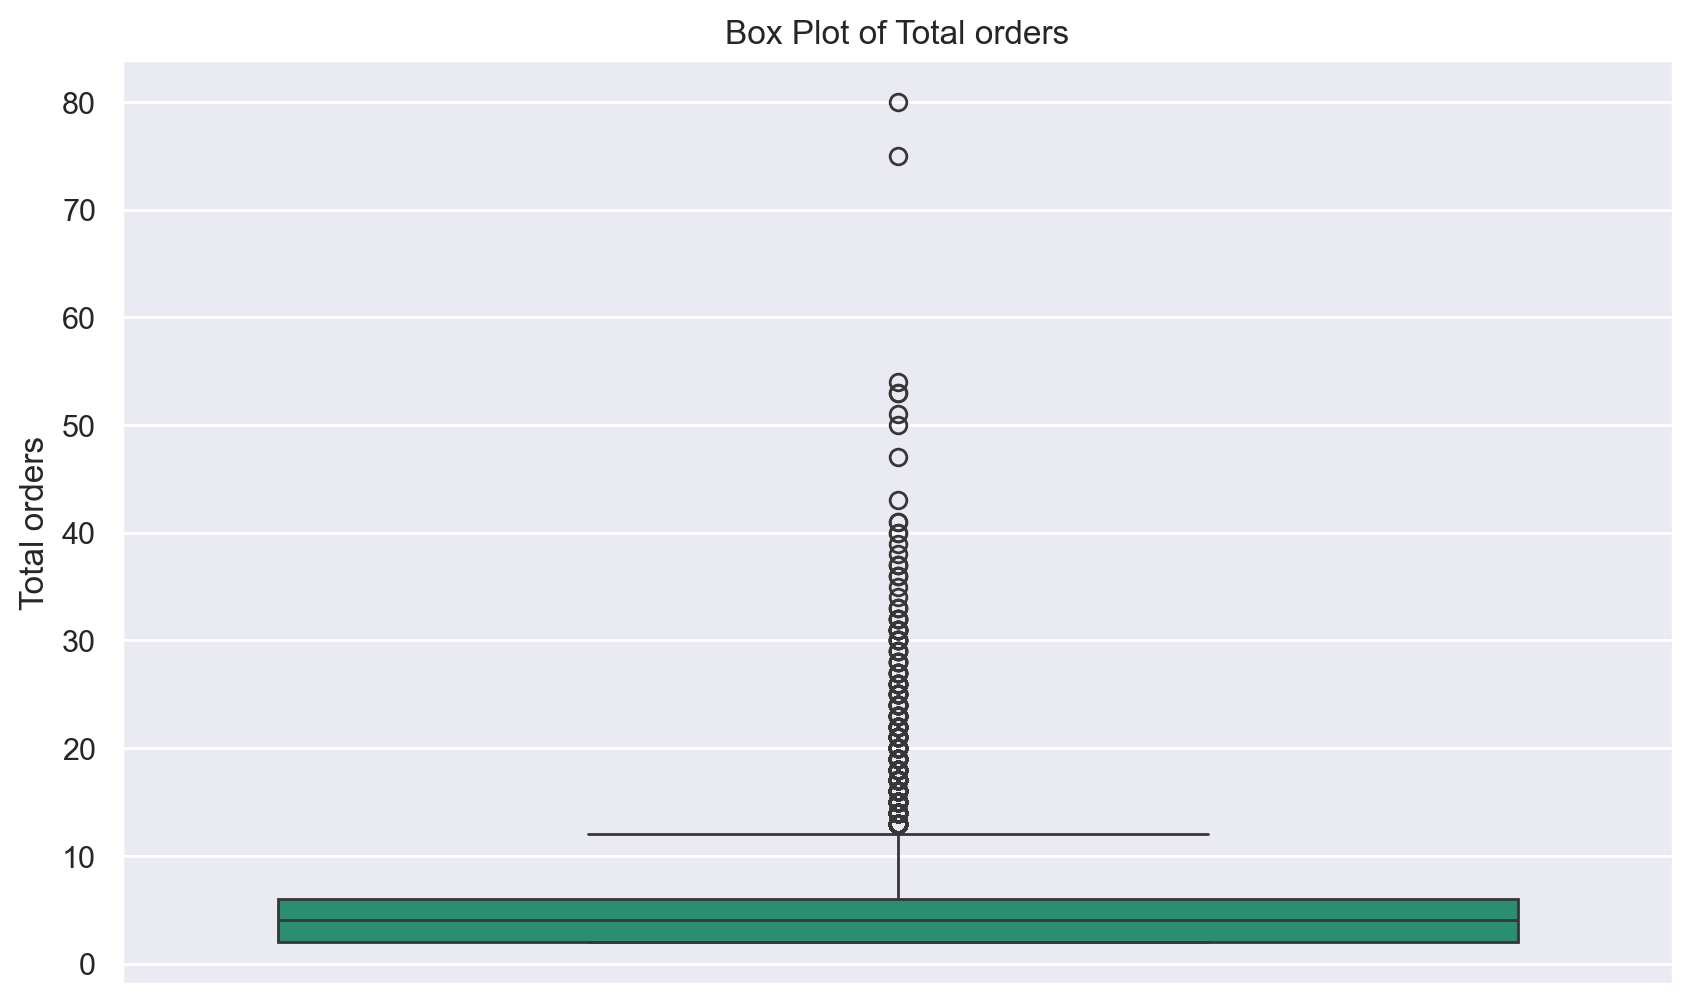

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='total_orders', palette='Dark2')
plt.title('Box Plot of Total orders')
plt.ylabel('Total orders')
plt.show()

In [45]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('total_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -10.0, and the upper limit is 18


In [46]:
out_total_orders = food_df[food_df['total_orders'] > ceil(extreme_upper_limit)] # saving outliers
out_total_orders ['total_orders'].describe().round(2)

count    746.00
mean      27.36
std       10.83
min       19.00
25%       21.00
50%       24.00
75%       30.00
max       94.00
Name: total_orders, dtype: float64

> - The were 746 extreme outliers identified.
> - The average value of the outliers identified is 27.36.
> - 50% of the outliers are below the value 24.
> - The lowest outlier has value 19 and the highest has value 94.

In [47]:
print(f"The dataset had {out_total_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['total_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 746 outliers.
Considering previous iterations, there are only 302 outliers left.


In [48]:
food_df_out = extreme_outliers_removal(food_df_out, 'total_orders', extreme_lower_limit, extreme_upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 92.24


__**Winsorization of values**__

In [49]:
lower_limit, upper_limit = boxplt_info('total_orders')
print(f"There are still {food_df_out[food_df_out['total_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 729 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [50]:
food_df_out['total_orders'] = np.clip(food_df_out['total_orders'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['total_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    Weekday

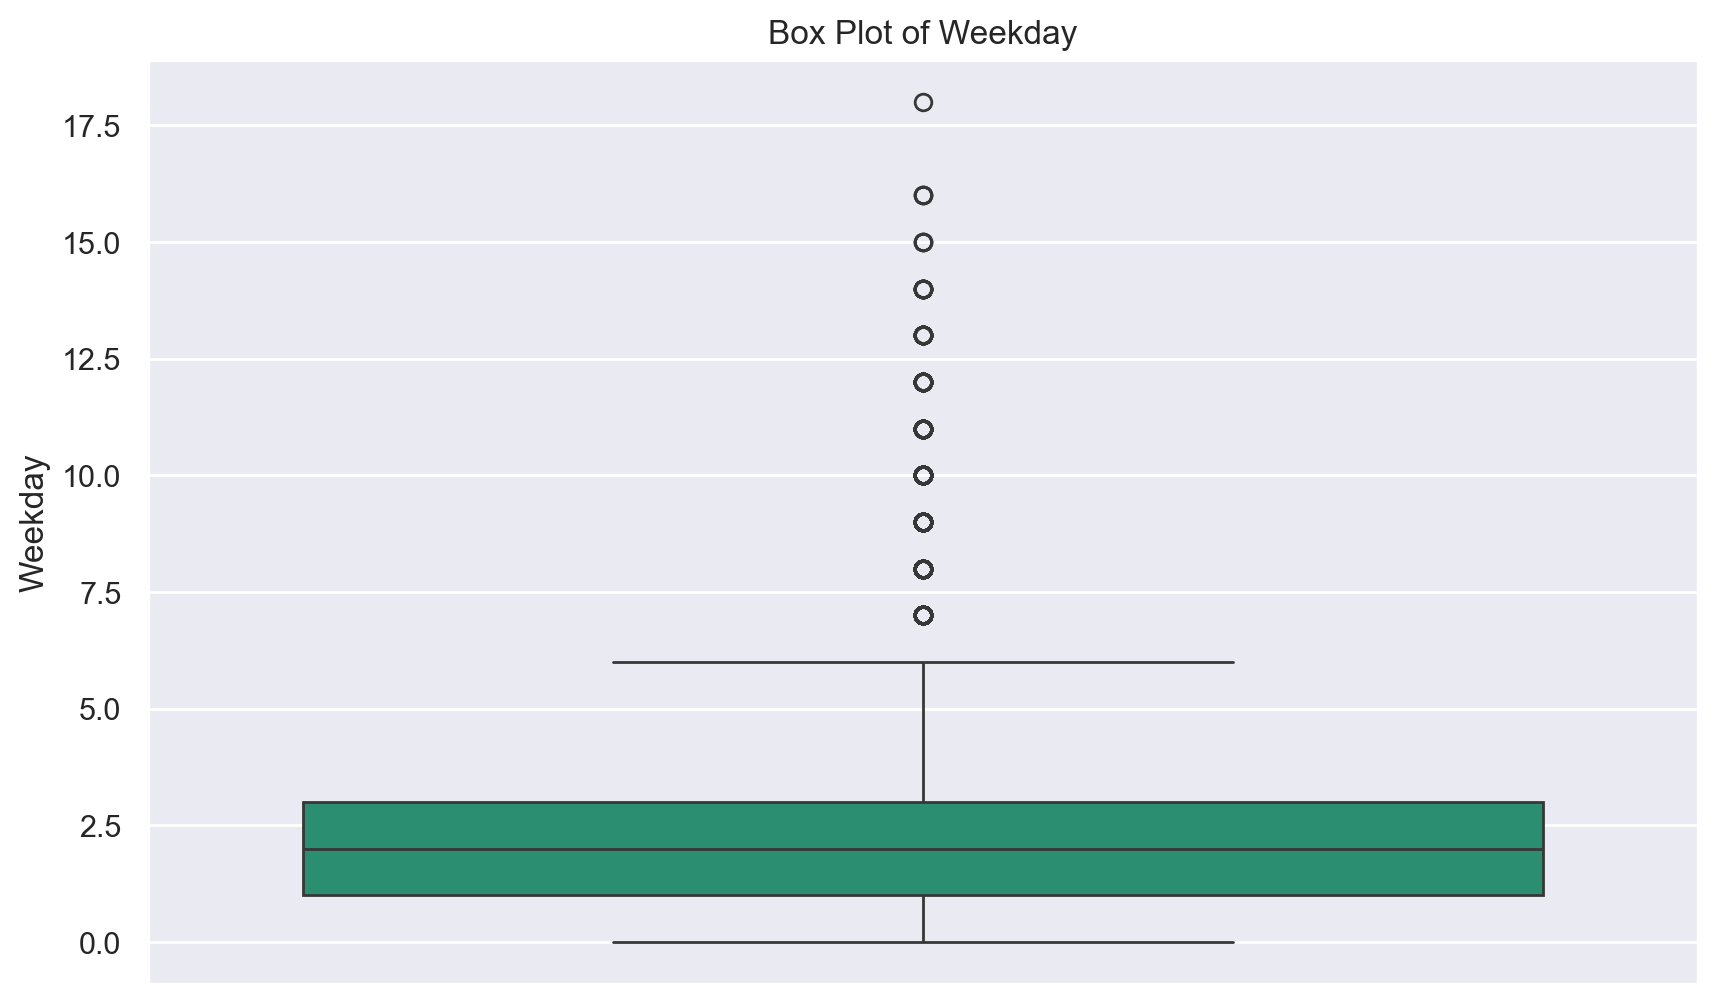

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='Weekday', palette='Dark2')
plt.title('Box Plot of Weekday')
plt.ylabel('Weekday')
plt.show()

In [52]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('Weekday')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -5.0, and the upper limit is 9


In [53]:
out_weekday = food_df[food_df['Weekday'] > extreme_upper_limit] # saving outliers 
out_weekday['Weekday'].describe().round(2)

count    1092.00
mean       14.53
std         6.14
min        10.00
25%        11.00
50%        13.00
75%        16.00
max        60.00
Name: Weekday, dtype: float64

> - The were 1092 extreme outliers identified.
> - The average value of the outliers identified is 14.53.
> - 50% of the outliers are below the value 13.
> - The lowest outlier has value 10 and the highest has value 60.

In [54]:
print(f"The dataset had {out_weekday.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['Weekday'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 1092 outliers.
Considering previous iterations, there are only 308 outliers left.


In [55]:
food_df_out = extreme_outliers_removal(food_df_out, 'Weekday', extreme_lower_limit, extreme_upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 91.0


__**Winsorization of values**__

In [56]:
lower_limit, upper_limit = boxplt_info('Weekday')
print(f"There are still {food_df_out[food_df_out['Weekday'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 983 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [57]:
food_df_out['Weekday'] = np.clip(food_df_out['Weekday'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['Weekday'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    midday_orders

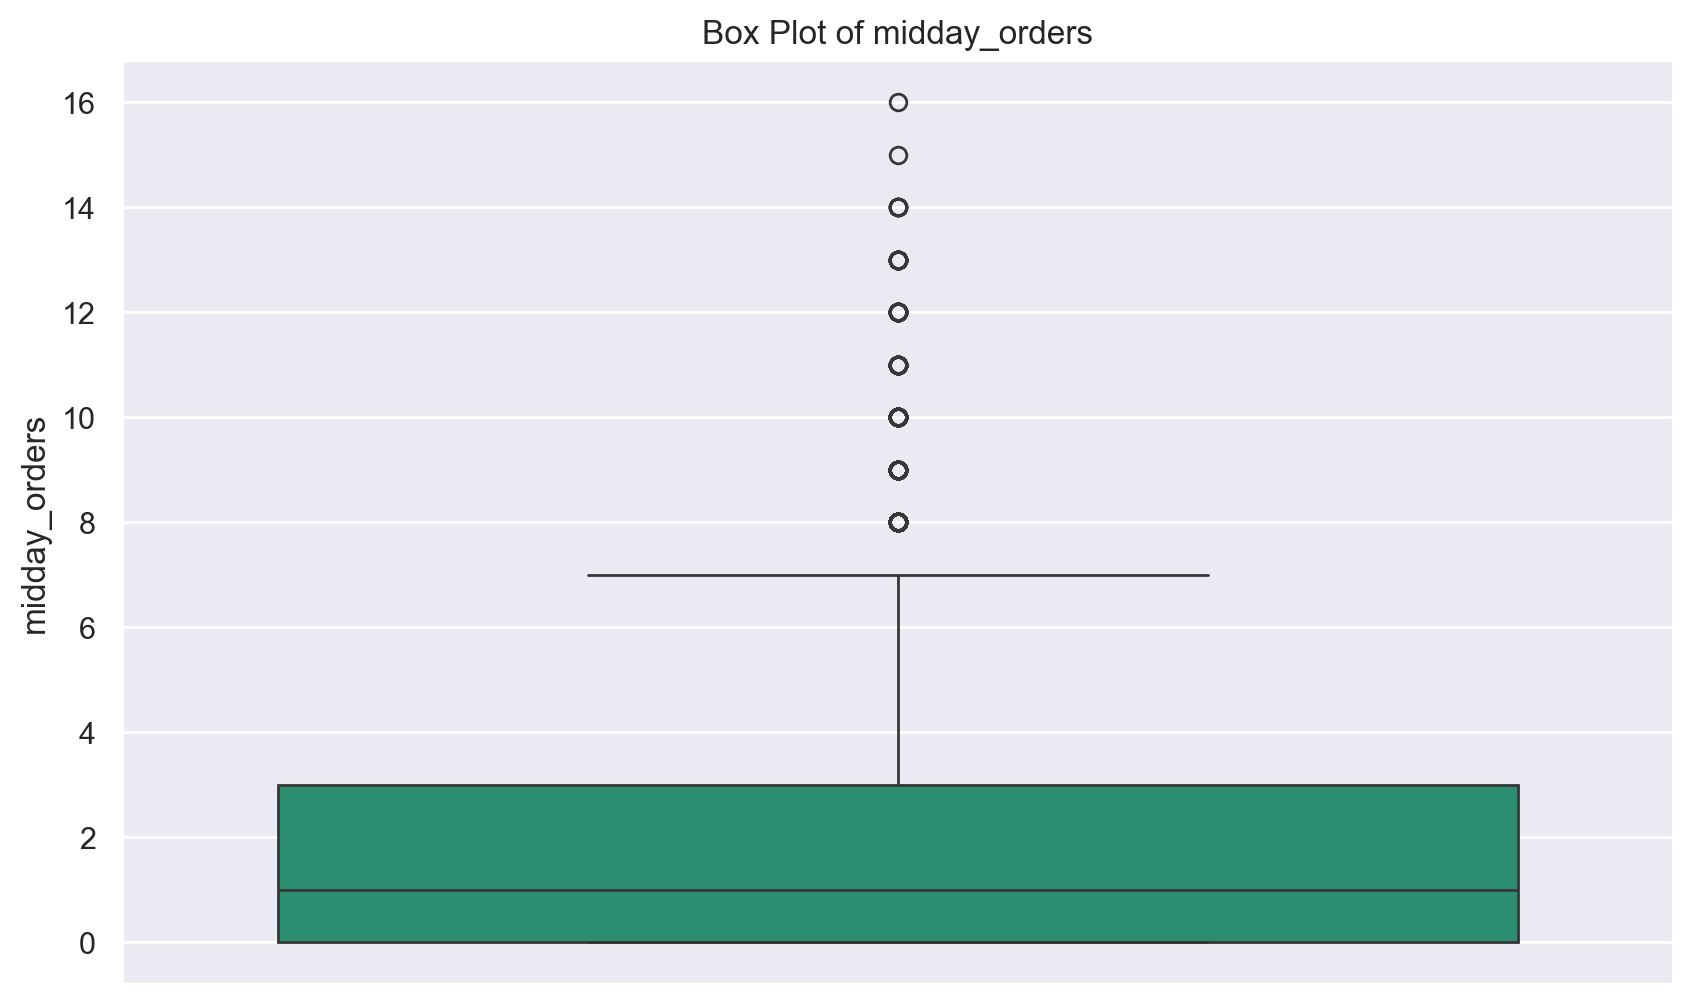

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='midday_orders', palette='Dark2')
plt.title('Box Plot of midday_orders')
plt.ylabel('midday_orders')
plt.show()

In [59]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('midday_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -5.0, and the upper limit is 9


In [60]:
out_midday_orders = food_df[food_df['midday_orders'] > extreme_upper_limit]
out_midday_orders['midday_orders'].describe().round(2)

count    823.00
mean      14.92
std        6.79
min       10.00
25%       11.00
50%       13.00
75%       16.00
max       71.00
Name: midday_orders, dtype: float64

> - The were 823 extreme outliers identified.
> - The average value of the outliers identified is 14.92.
> - 50% of the outliers are below the value 13.
> - The lowest outlier has value 10 and the highest has value 71.

In [61]:
print(f"The dataset had {out_midday_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['midday_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 823 outliers.
Considering previous iterations, there are only 160 outliers left.


In [62]:
food_df_out = extreme_outliers_removal(food_df_out, 'midday_orders', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 90.35


__**Winsorization of values**__

In [63]:
lower_limit, upper_limit = boxplt_info('midday_orders')
print(f"There are still {food_df_out[food_df_out['midday_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 638 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [64]:
food_df_out['midday_orders'] = np.clip(food_df_out['midday_orders'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['midday_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    evening_orders

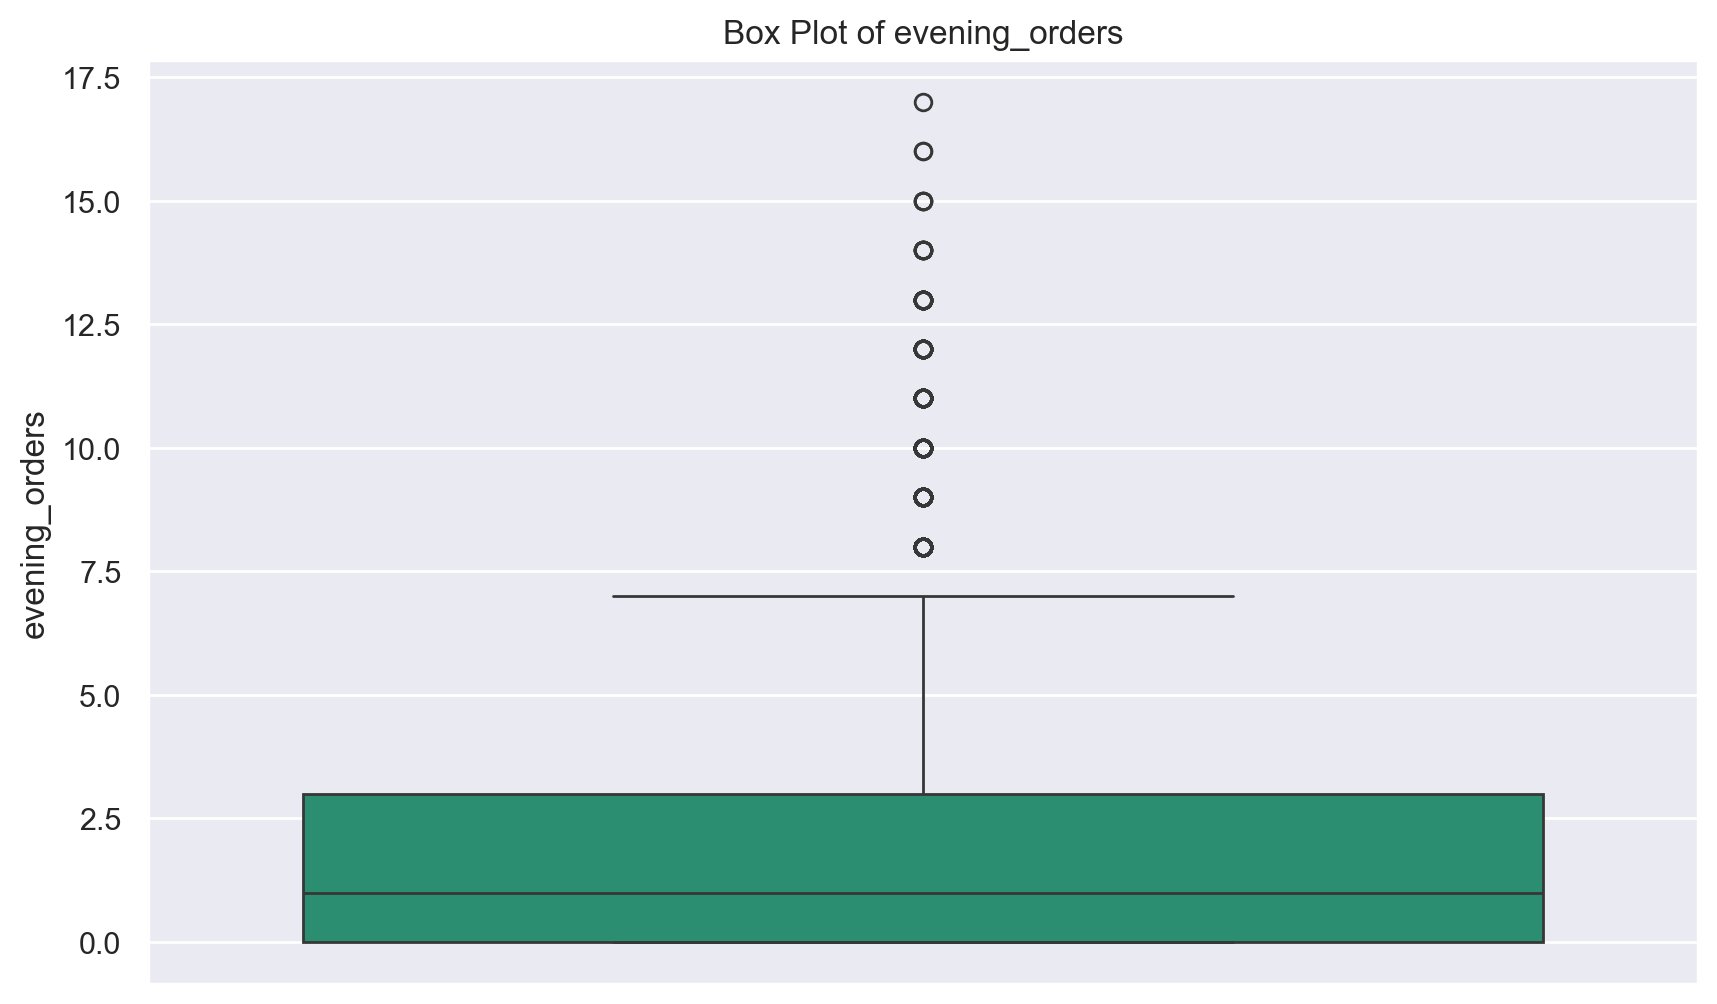

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='evening_orders', palette='Dark2')
plt.title('Box Plot of evening_orders')
plt.ylabel('evening_orders')
plt.show()

In [66]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('evening_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -9.0, and the upper limit is 12


In [67]:
out_evening_orders = food_df[food_df['evening_orders'] > extreme_upper_limit] 
out_evening_orders['evening_orders'].describe().round(2)

count    409.00
mean      17.96
std        6.66
min       13.00
25%       14.00
50%       16.00
75%       20.00
max       61.00
Name: evening_orders, dtype: float64

> - The were 409 extreme outliers identified.
> - The average value of the outliers identified is 17.96.
> - 50% of the outliers are below the value 16.
> - The lowest outlier has value 13 and the highest has value 61.

In [68]:
print(f"The dataset had {out_evening_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['evening_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 409 outliers.
Considering previous iterations, there are only 42 outliers left.


In [69]:
food_df_out = extreme_outliers_removal(food_df_out, 'evening_orders', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 90.18


__**Winsorization of values**__

In [70]:
lower_limit, upper_limit = boxplt_info('evening_orders')
print(f"There are still {food_df_out[food_df_out['evening_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 342 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [71]:
food_df_out['evening_orders'] = np.clip(food_df_out['evening_orders'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['evening_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    total_spent

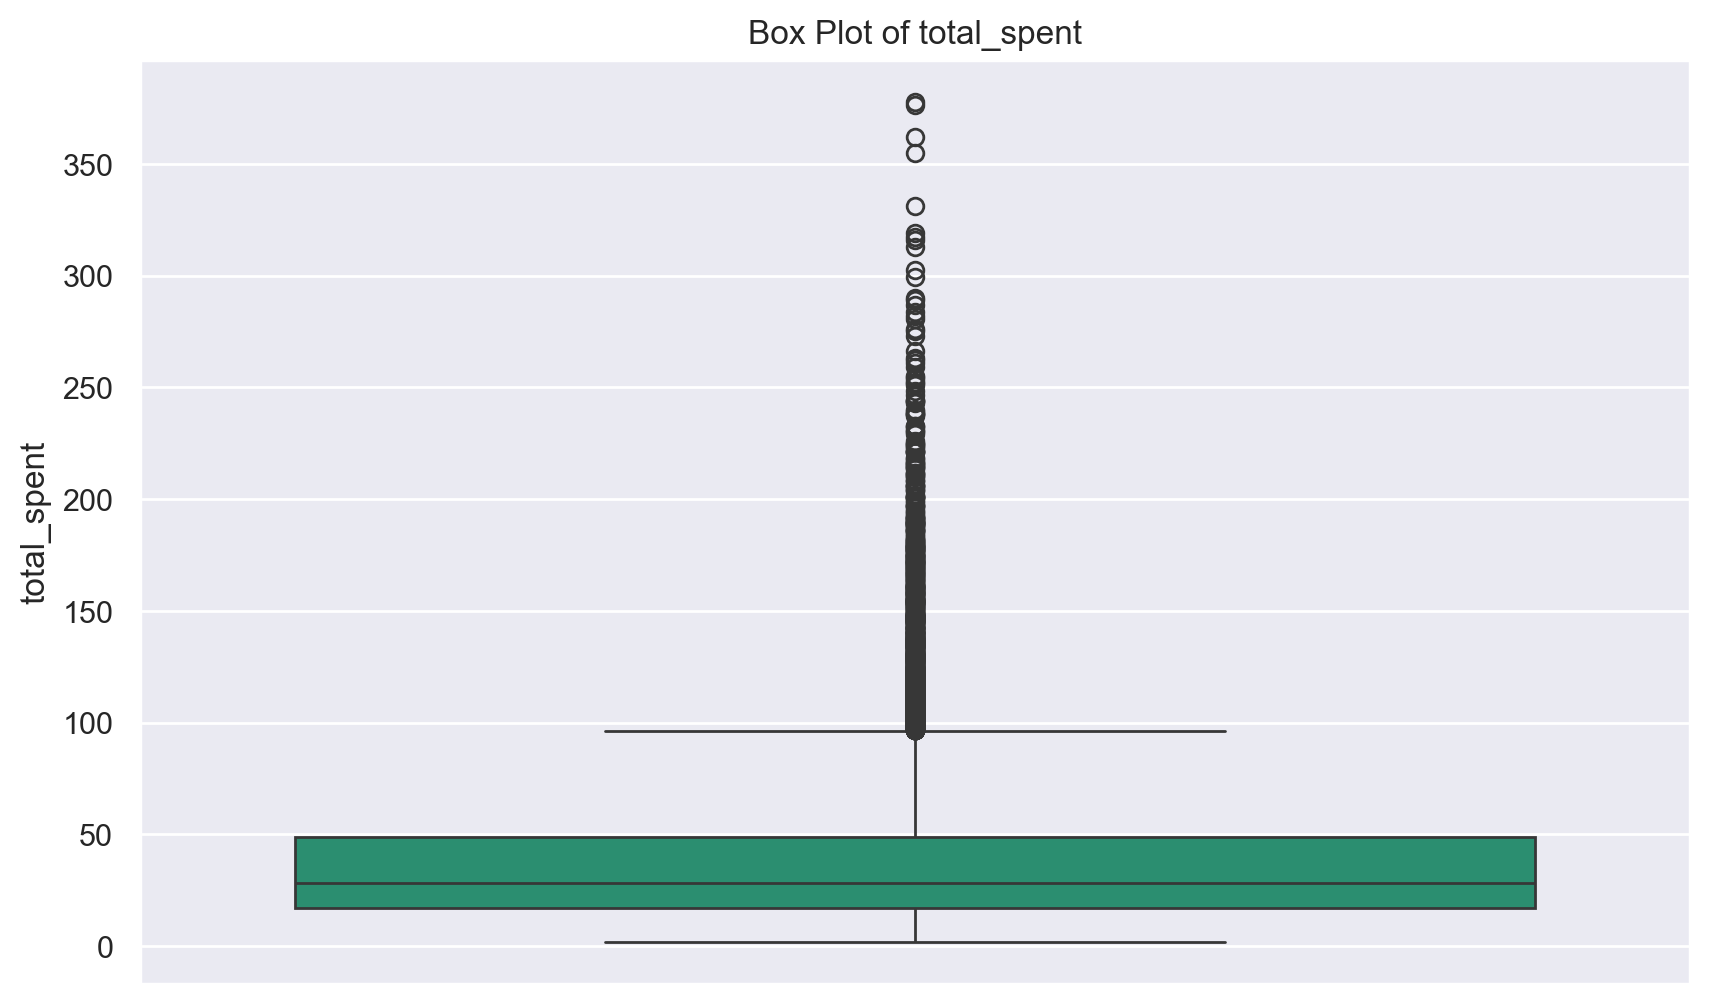

In [72]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='total_spent', palette='Dark2')
plt.title('Box Plot of total_spent')
plt.ylabel('total_spent')
plt.show()

In [73]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('total_spent')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -94.15, and the upper limit is 167


In [74]:
out_total_spent = food_df[food_df['total_spent'] > extreme_upper_limit]
out_total_spent['total_spent'].describe().round(2)

count     750.00
mean      244.76
std        99.64
min       167.10
25%       185.51
50%       213.96
75%       268.87
max      1418.33
Name: total_spent, dtype: float64

> - The were 750 extreme outliers identified.
> - The average value of the outliers identified is 244.76.
> - 50% of the outliers are below the value 213.96.
> - The lowest outlier has value 167 and the highest has value 1418.

In [75]:
print(f"The dataset had {out_total_spent.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['total_spent'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 750 outliers.
Considering previous iterations, there are only 243 outliers left.


In [76]:
food_df_out = extreme_outliers_removal(food_df_out, 'total_spent', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 89.21


__**Winsorization of values**__

In [77]:
lower_limit, upper_limit = boxplt_info('total_spent')
print(f"There are still {food_df_out[food_df_out['total_spent'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 701 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [78]:
food_df_out['total_spent'] = np.clip(food_df_out['total_spent'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['total_spent'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    Weekend

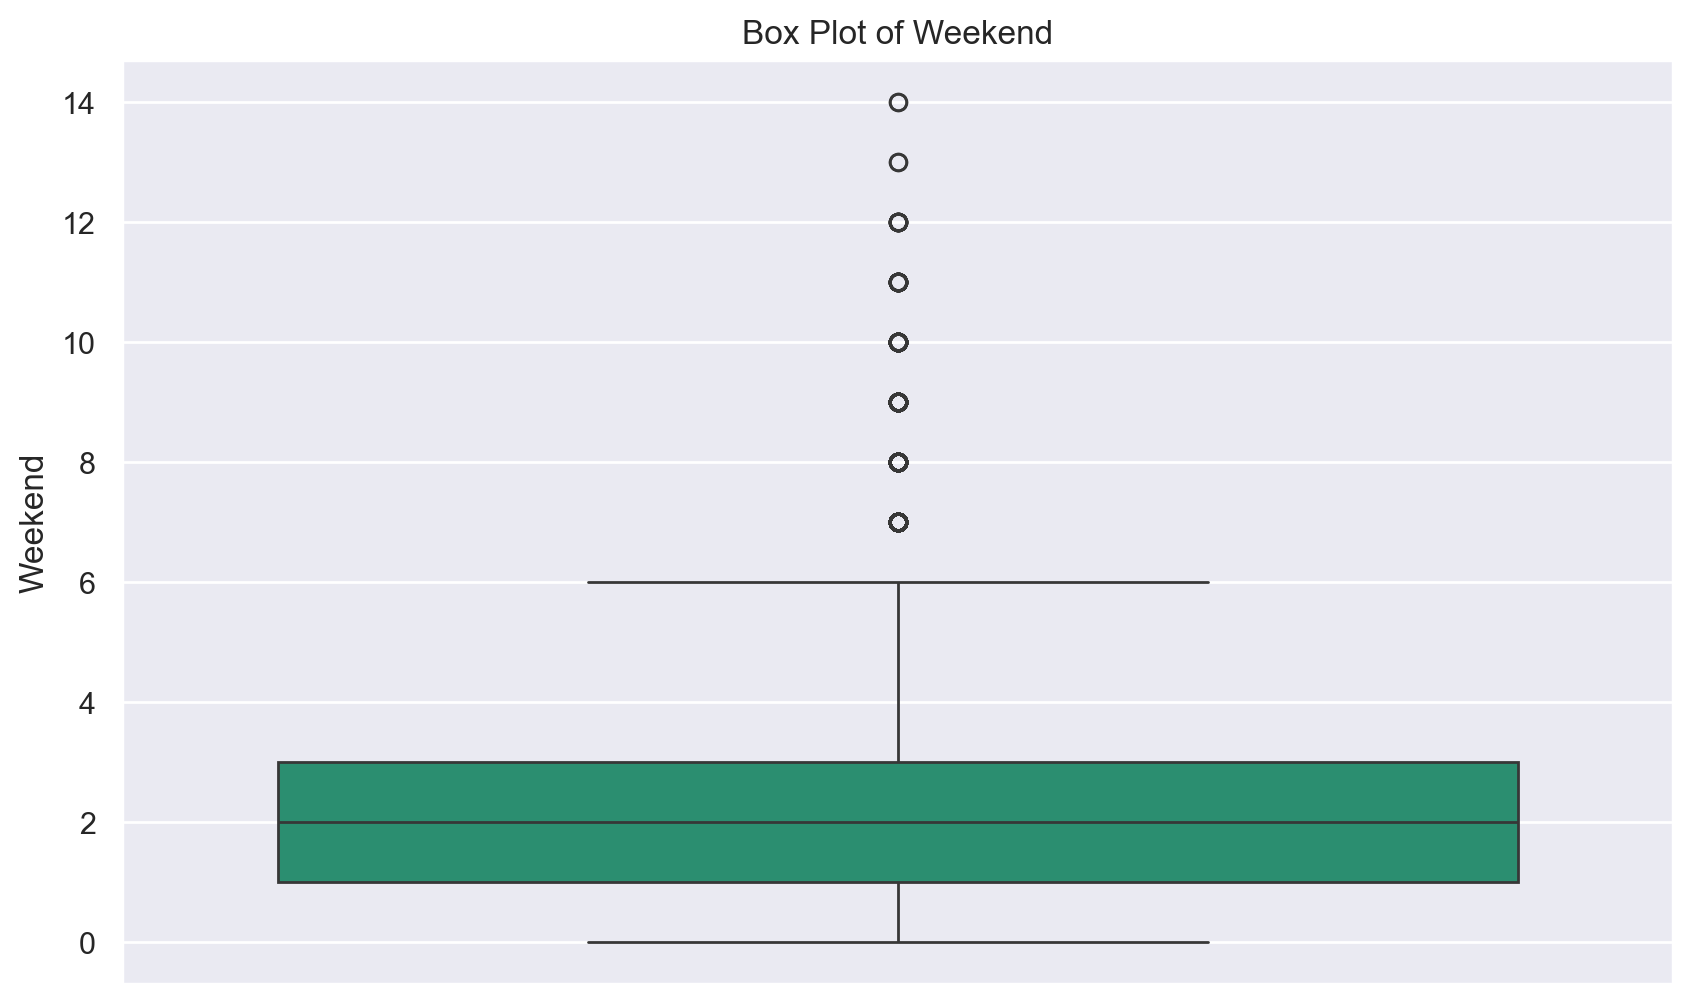

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='Weekend', palette='Dark2')
plt.title('Box Plot of Weekend')
plt.ylabel('Weekend')
plt.show()

In [80]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('Weekend')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -5.0, and the upper limit is 9


In [81]:
out_Weekend = food_df[food_df['Weekend'] > extreme_upper_limit] # saving outliers
out_Weekend['Weekend'].describe().round(2)

count    595.00
mean      13.96
std        5.13
min       10.00
25%       10.50
50%       12.00
75%       15.50
max       45.00
Name: Weekend, dtype: float64

> - The were 595 extreme outliers identified.
> - The average value of the outliers identified is 13.96.
> - 50% of the outliers are below the value 12.
> - The lowest outlier has value 10 and the highest has value 45.

In [82]:
print(f"The dataset had {out_Weekend.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['Weekend'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 595 outliers.
Considering previous iterations, there are only 74 outliers left.


In [83]:
food_df_out = extreme_outliers_removal(food_df_out, 'Weekend', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 88.91


__**Winsorization of values**__

In [84]:
lower_limit, upper_limit = boxplt_info('Weekend')
print(f"There are still {food_df_out[food_df_out['Weekend'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 450 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [85]:
food_df_out['Weekend'] = np.clip(food_df_out['Weekend'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['Weekend'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    late_night_orders

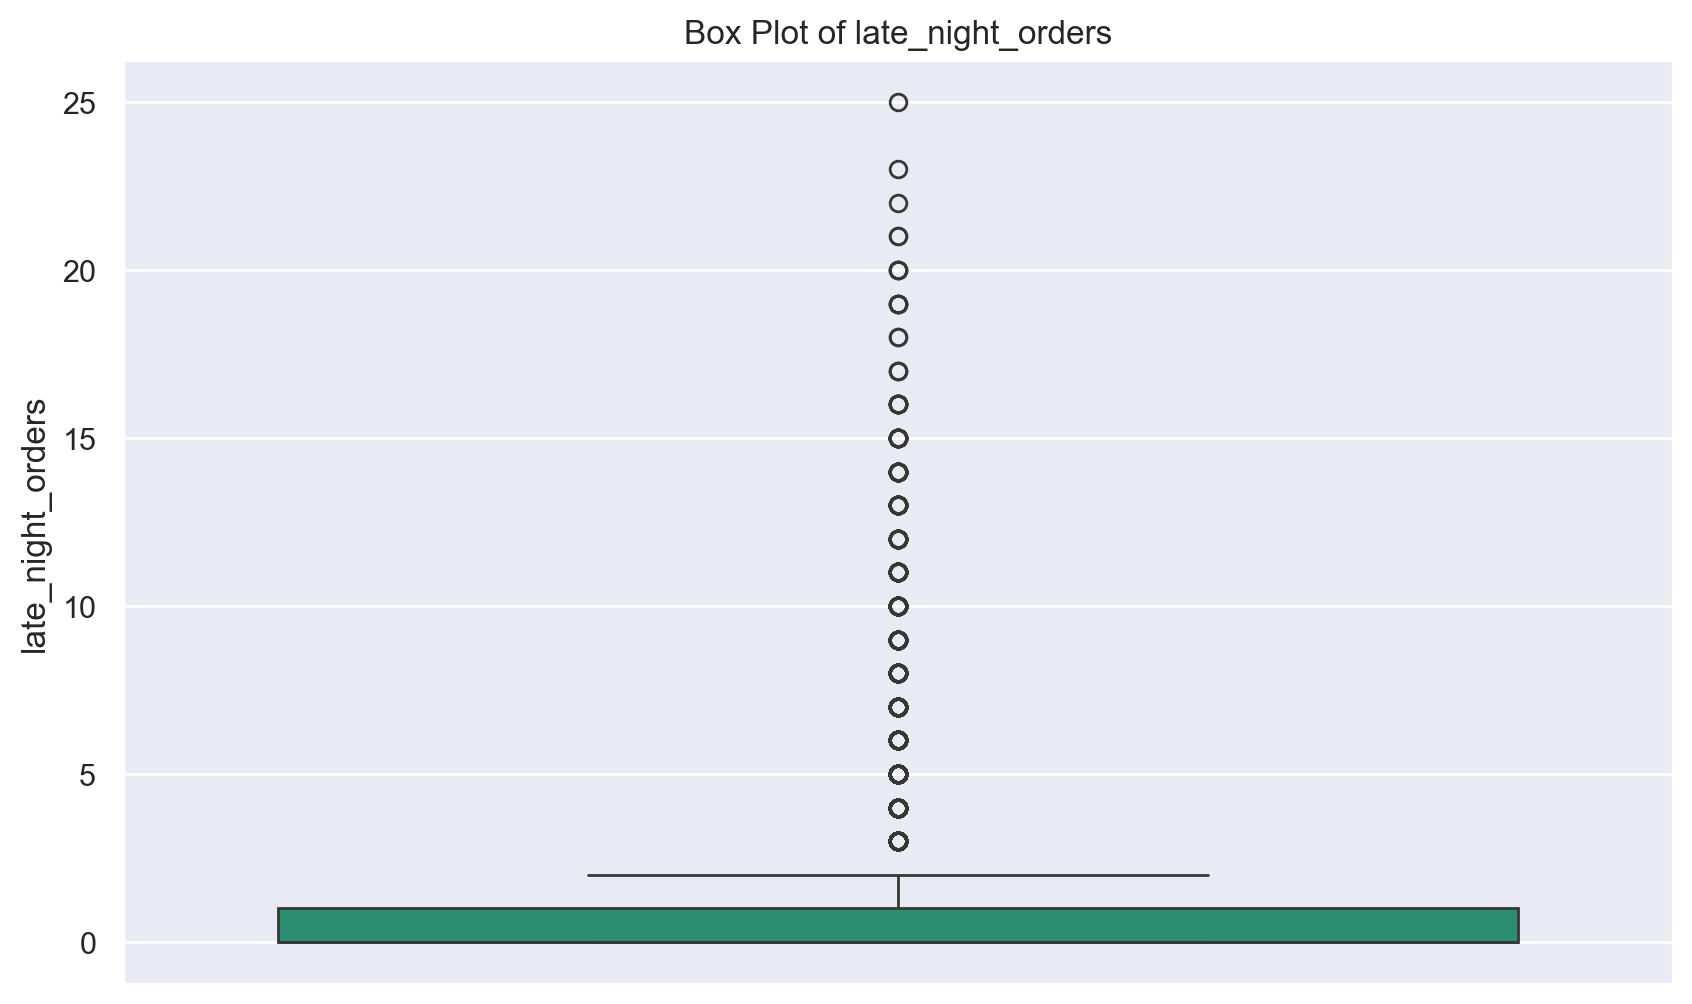

In [86]:
# plotting the graph with some of the outliers already removed for simplicity purposes
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='late_night_orders', palette='Dark2')
plt.title('Box Plot of late_night_orders')
plt.ylabel('late_night_orders')
plt.show()

In [87]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('late_night_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -3.0, and the upper limit is 4


In [88]:
out_late_night_orders = food_df[food_df['late_night_orders'] > extreme_upper_limit] # saving outliers
out_late_night_orders['late_night_orders'].describe().round(2)

count    1325.00
mean       10.37
std         8.17
min         5.00
25%         6.00
50%         8.00
75%        12.00
max        81.00
Name: late_night_orders, dtype: float64

> - The were 1325 extreme outliers identified.
> - The average value of the outliers identified is 10.37.
> - 50% of the outliers are below the value 8.
> - The lowest outlier has value 5 and the highest has value 81.

In [89]:
print(f"The dataset had {out_late_night_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['late_night_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 1325 outliers.
Considering previous iterations, there are only 903 outliers left.


In [90]:
food_df_out = extreme_outliers_removal(food_df_out, 'late_night_orders', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 85.27


__**Plotting Box Plots**__

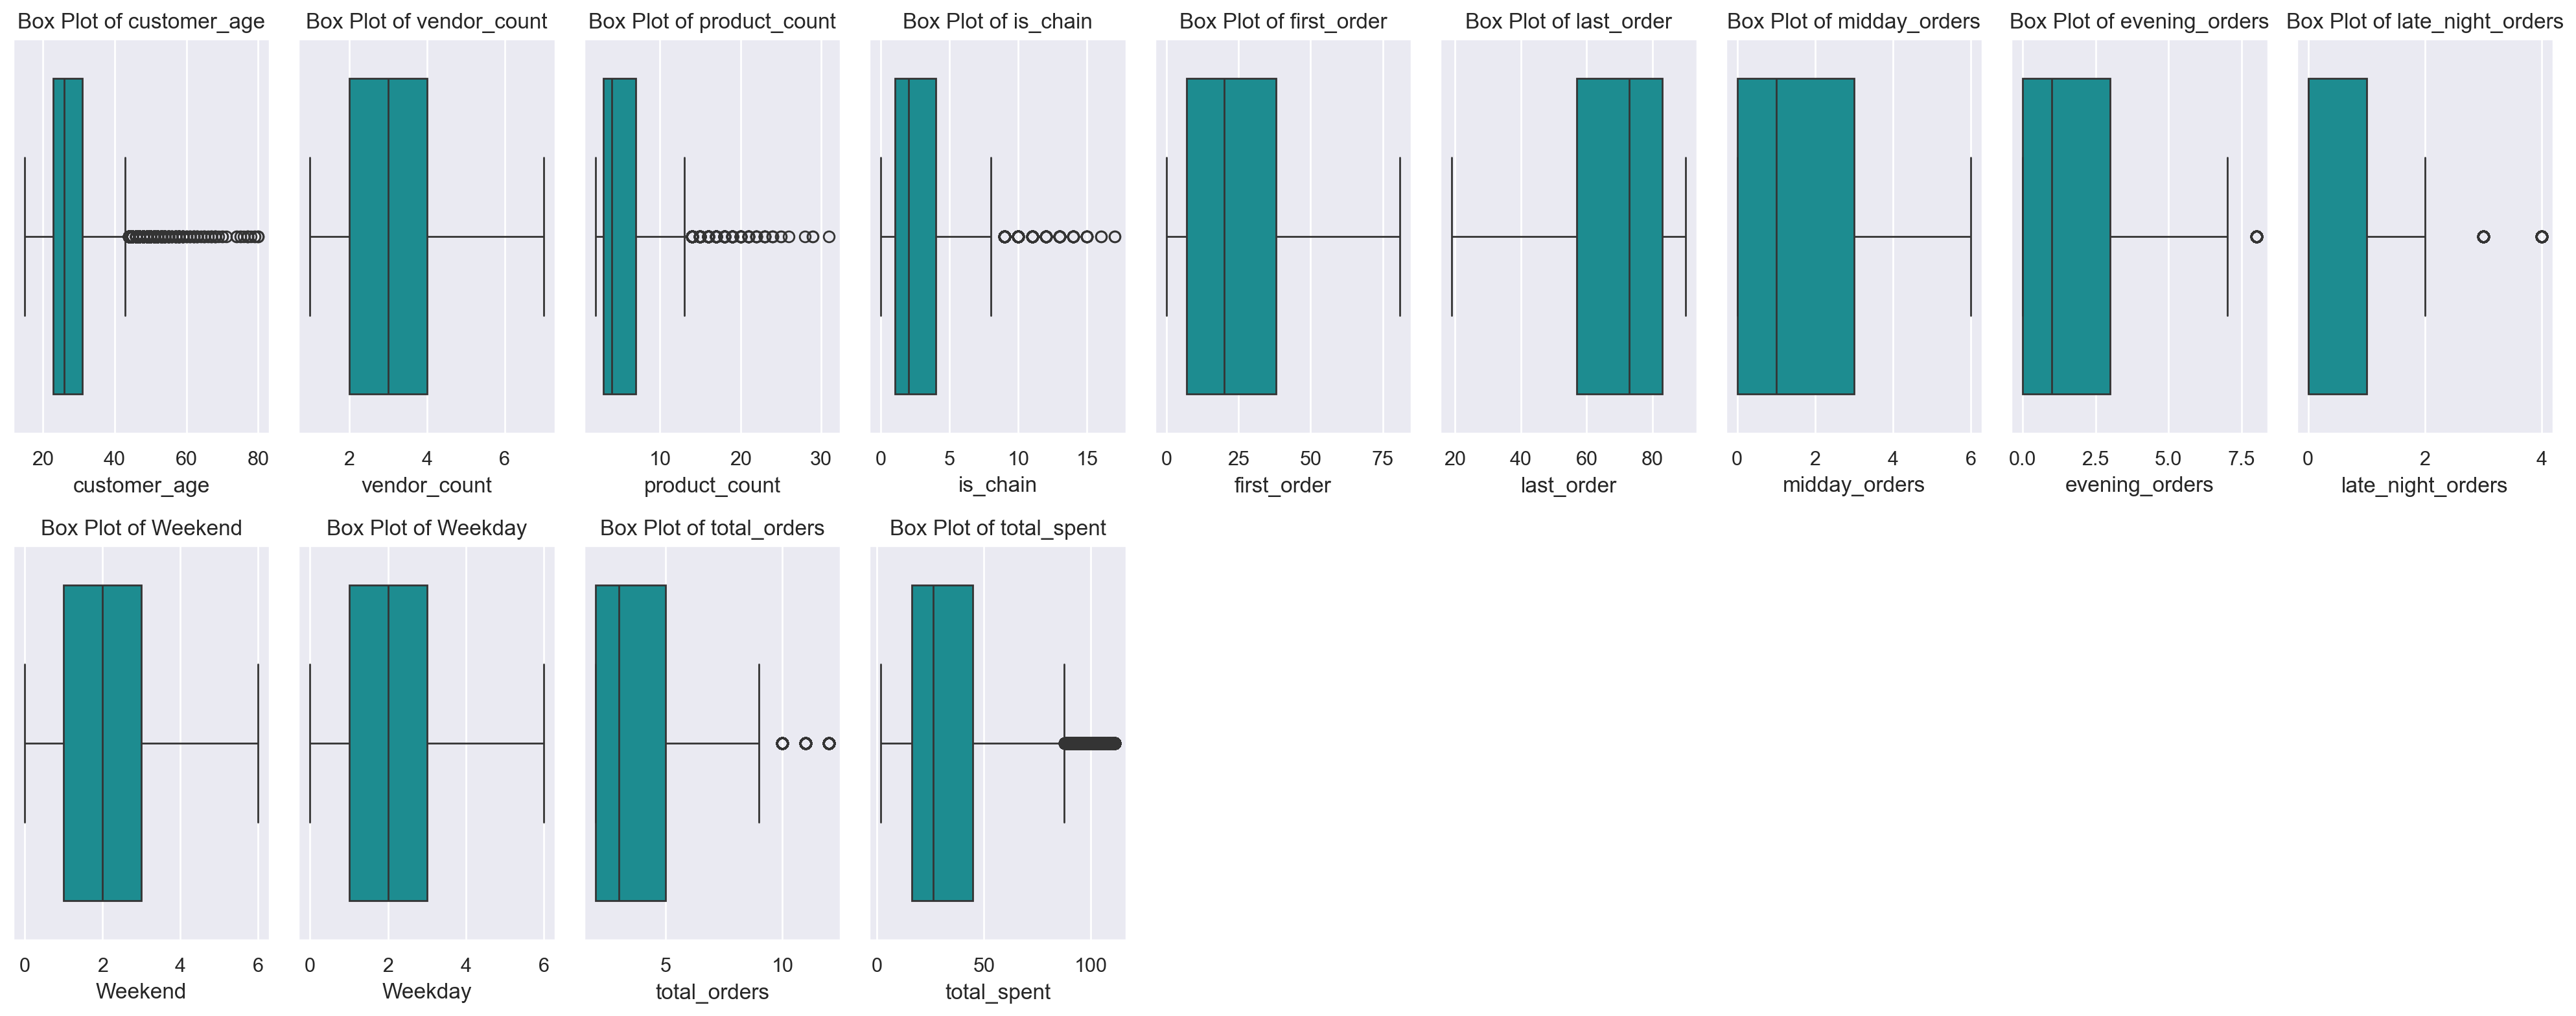

In [91]:
# Final boxplots of all numerical variables
n_cols = 9
n_rows = -(-len(num_columns_without_CUI) // n_cols)  # Calculate rows needed

# Set the figure size for readability
plt.figure(figsize=(20, 4 * n_rows))

# Plot each numerical column in a separate horizontal box plot
for i, column in enumerate(num_columns_without_CUI, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=food_df_out, x=column, color = colors['BL'])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

In [92]:
food_df = food_df_out #updating our current dataset

__**Addressing `is_chain` Inconsistency**__

In [93]:
print(f"There are {len(food_df[(food_df['total_orders'] == 12) & (food_df['is_chain'] > 12)])} records where 'is_chain' is greater than 'total_orders'.")

There are 68 records where 'is_chain' is greater than 'total_orders'.


> - Because we treated outliers only for total_orders and not for is_chain, which is in relation to the first column mentioned, we wanted to check if we had some incoherent values (rows where is_chain is now bigger than total_orders).
> - We got a return of 100 records, so we just decided to set all of these to the `total_orders` value as we believe it describes our data properly. This happened because we Winsorized the values previously.

In [94]:
food_df.loc[(food_df['total_orders'] == 12) & (food_df['is_chain'] > 12), 'is_chain'] = food_df['total_orders']
print(f"There are {len(food_df[(food_df['total_orders'] == 12) & (food_df['is_chain'] > 12)])} records where 'is_chain' is greater than 'total_orders'.")

There are 0 records where 'is_chain' is greater than 'total_orders'.


## 5. Feature Engineering

In this section, we will  create and explore new features that may be relevant for our segmentation. We are creating features from variables where outliers were already treated so we believe our data is robust.

`is_one_time_customer`

> - We used this feature to easily assess if a customer only made one order or is a returning customer.
> - We used this previously to separate our dataset, as we believe this separation will allow us to better understand the customers behaviors.
> - It is a binary variable that is '1' if the customer only bought 1 time and '0' otherwise. It was applied to both datasets.

    average_spent_per_order

> We wanted to see the average amount of money spent per customer on one order. <br>
> This feature can help us identify trends with customer's spending habits.

In [95]:
food_df['average_spent_per_order'] = (food_df['total_spent'] / food_df['total_orders']).round(2)

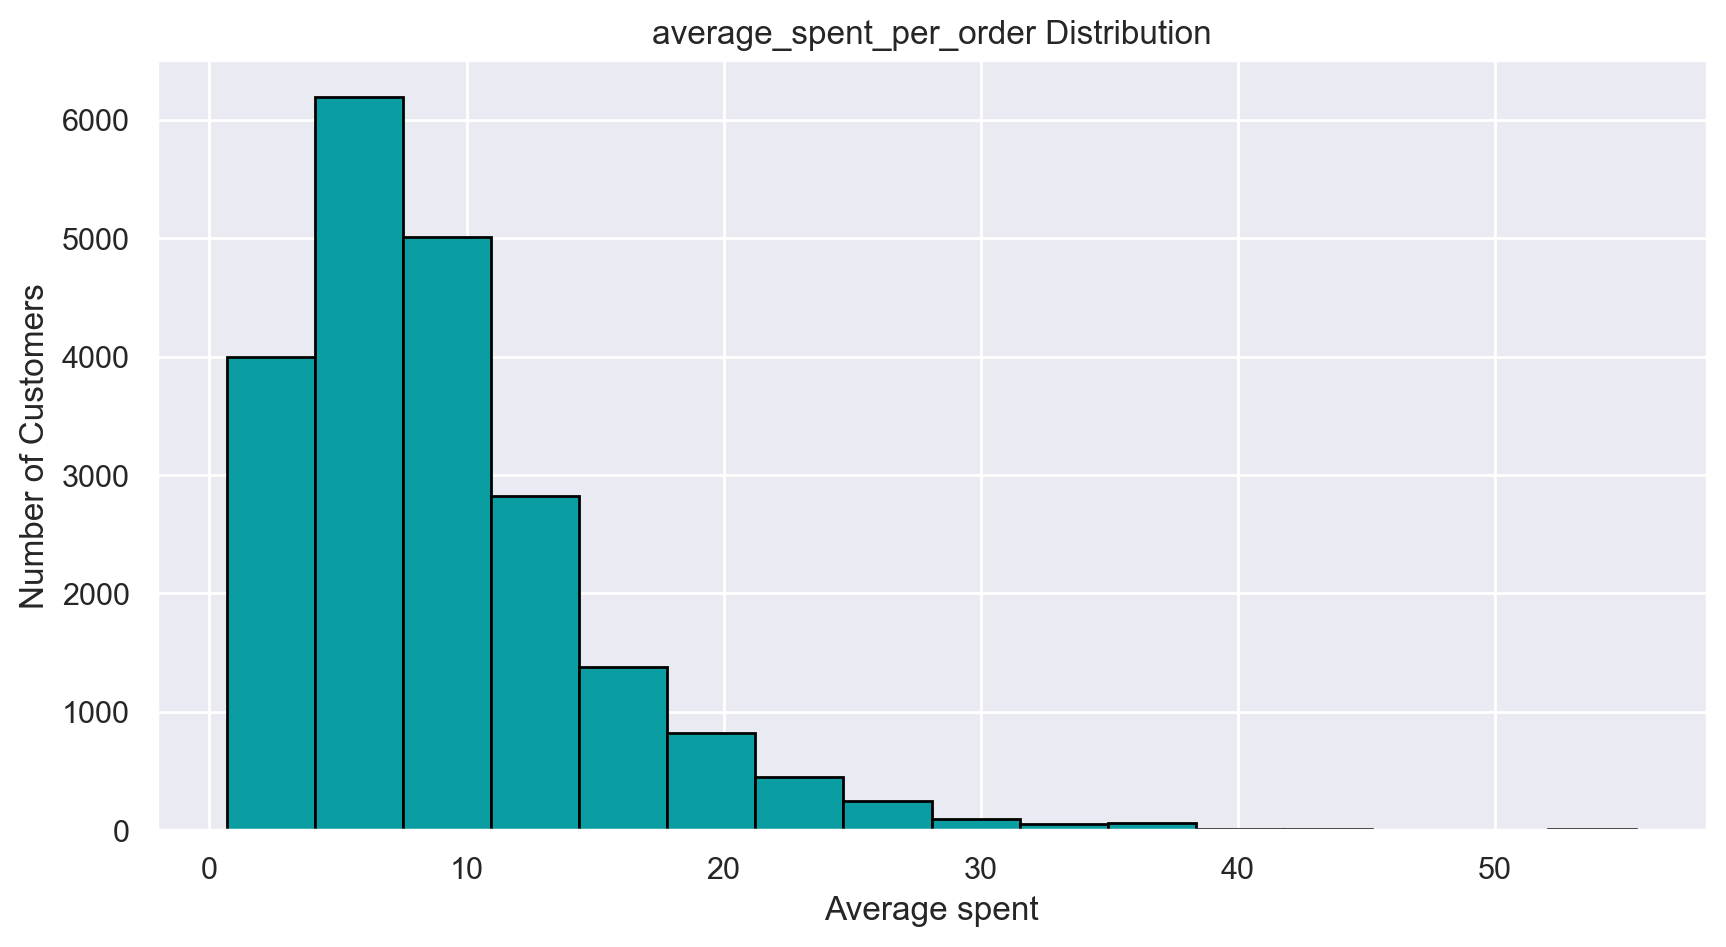

In [96]:
plt.figure(figsize=(10, 5))
plt.hist(food_df['average_spent_per_order'], bins=number_bins_sturges(food_df['average_spent_per_order']), color=colors["BL"], edgecolor='black')
plt.title('average_spent_per_order Distribution')
plt.xlabel('Average spent')
plt.ylabel('Number of Customers')
plt.show()

> - Right Skewed Distribution with values from 0.68 to 55.5.
> - We can see the presence of some cases where more money was spent per order.

    customer_lifetime

In [97]:
food_df['customer_lifetime'] = food_df['last_order'].max() - food_df['first_order']
food_df['customer_lifetime'].describe().round(2)

count    21172.00
mean        64.96
std         20.40
min          9.00
25%         52.00
50%         70.00
75%         83.00
max         90.00
Name: customer_lifetime, dtype: float64

> - Our customers have a lifetime, on average, of 65 days.
> - This is without considering the one-time customers.

`food_diversity_index`

> - The Herfindahl-Hirschman Index (HHI) is commonly used to measure concentration (or diversity) in various contexts, in this case, customer spending diversity. 
> - Higher HHI indicates less diversity (more concentration in fewer categories).
> - Lower HHI indicates greater diversity (more evenly spread spending across categories).
> - Source: <a href=https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index> Herfindahl–Hirschman Index - Wikipedia </a> 

In [98]:
CUI_features = ['CUI_Healthy', 'CUI_OTHER','CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']
def calculate_hhi(row, cuisine_columns):
    # Get total spending for the customer
    total_spent = row[cuisine_columns].sum()
    
    # If total spending is 0, return 0 (no diversity)
    if total_spent == 0:
        return 0
    
    # Calculate the proportions of spending for each cuisine
    proportions = row[cuisine_columns] / total_spent
    
    # Calculate the Herfindahl-Hirschman Index
    hhi = np.sum(proportions**2)
    return hhi

# Apply the HHI function to each row (customer)
food_df['food_diversity_hhi'] = food_df.apply(calculate_hhi, axis=1, cuisine_columns=CUI_features) # higher gini means less diversity


In [99]:
food_df['food_diversity_hhi'].describe().round(2)

count    21172.00
mean         0.69
std          0.24
min          0.20
25%          0.51
50%          0.61
75%          1.00
max          1.00
Name: food_diversity_hhi, dtype: float64

On average, customer have a percentage of 69% of food diveristy

After evaluation and testing the clusters, we decided that although the food diversity column was important, it was best to have it as a categorical feature, instead of numerical.

In [100]:
# Define bins for categorizing HHI
# HHI close to 1 = less diversity
# HHI close to 0 = more diversity
bins = [0, 0.33, 0.66, 1]  # Define the cut points
labels = ['High Diversity', 'Medium Diversity', 'Low Diversity']

#Creating the categorical variable based on the bins
food_df['food_diversity_category'] = pd.cut(
    food_df['food_diversity_hhi'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

#Checking the results
food_df[['food_diversity_hhi', 'food_diversity_category']].head(5)


,food_diversity_hhi,food_diversity_category
customer_id,,
40b5c1bf89,0.501225,Medium Diversity
c79709f885,0.741773,Low Diversity
273bf88a7a,0.426459,Medium Diversity
986ffd3978,1.000000,Low Diversity
a9bac03d6b,1.000000,Low Diversity


In [101]:
#Changing the datatype
food_df['food_diversity_category'] = food_df['food_diversity_category'].astype('object')


In [102]:
#Checking how the categories are distributed
food_df['food_diversity_category'].value_counts()

food_diversity_category
Medium Diversity    11327
Low Diversity        9375
High Diversity        470
Name: count, dtype: int64

After evaluation, we realized that the food_diversity_hhi columns was actually decreasing the scores of the algorithms, hence. we decided to drop this feature, and keep the categorical one

In [103]:
#Dropping the food_diversity_hhi column
food_df = food_df.drop(columns = 'food_diversity_hhi')

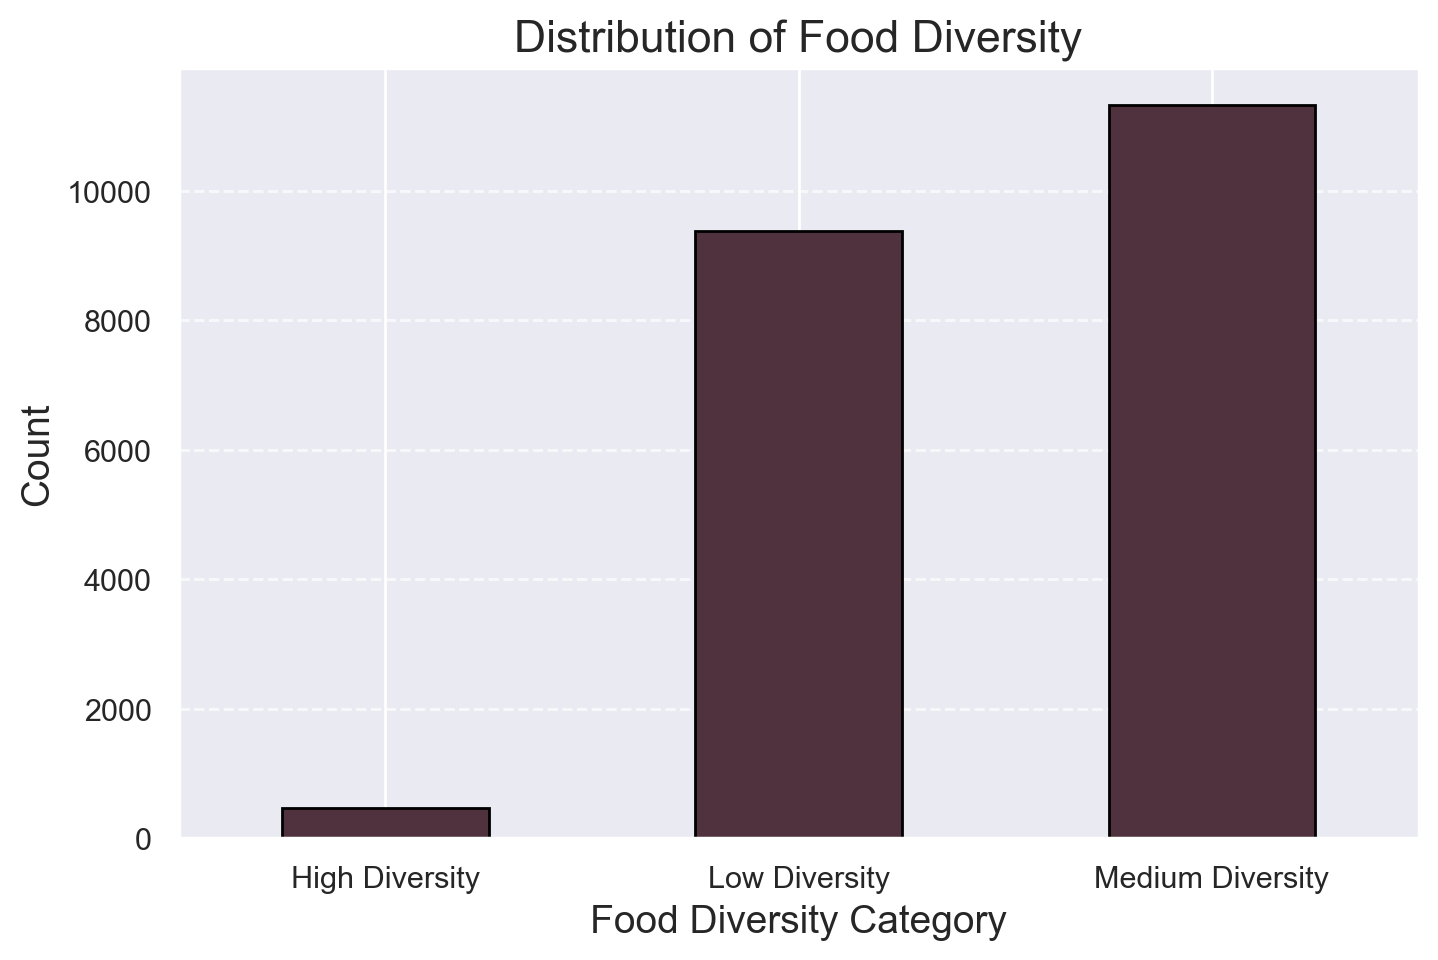

In [104]:
# Count the occurrences of each category
category_counts = food_df['food_diversity_category'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 5))
category_counts.sort_index().plot(kind='bar', color=colors["BR"], edgecolor='black')

# Add title and labels
plt.title('Distribution of Food Diversity', fontsize=16)
plt.xlabel('Food Diversity Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()

As we can see, the category of food diversity with he most customers, is the "Medium diversity"

    percent_chain_orders

> - We wanted to categorize our customer based on how much of their purchases are from chain restaurants. 
> - For this, we decided to create a variable that assign categories based on the percentages of is_chain orders from total_orders.
> - We believe this will help us gain insights into customer behavior.

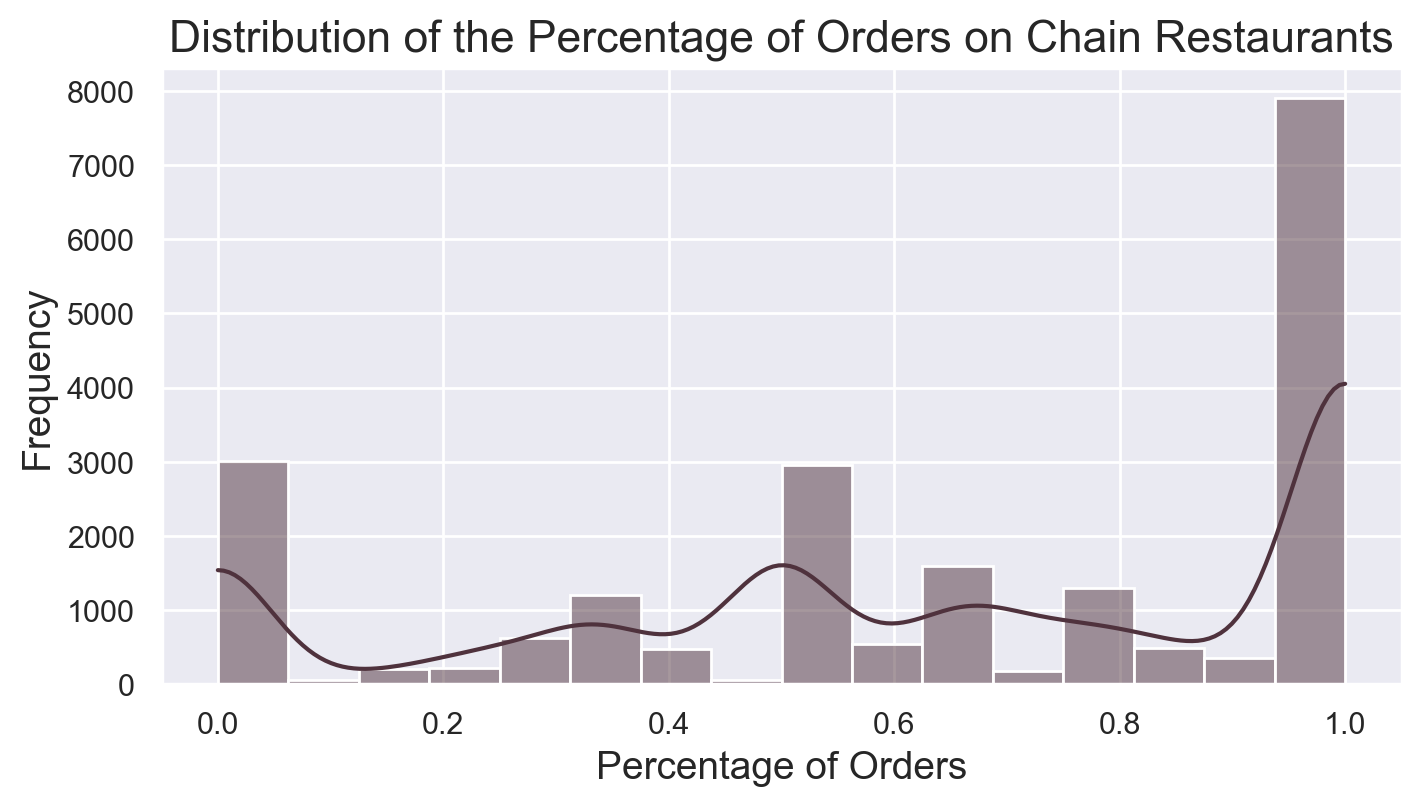

In [105]:
food_df['percent_chain_orders'] = (food_df['is_chain'] / food_df['total_orders'].replace(0, np.nan)).round(3) #Getting the percentage chain orders
plt.figure(figsize=(8, 4))
sns.histplot(food_df['percent_chain_orders'].dropna(), bins=number_bins_sturges(food_df['percent_chain_orders']), kde=True, color=colors["BR"])
plt.title('Distribution of the Percentage of Orders on Chain Restaurants', fontsize=16)
plt.xlabel('Percentage of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

> - We can observe more frequency towards the right side of the graph, which indicates that a lot of people that order from chain restaurants, mostly order from these type of establishments.

In [106]:
#Create categorical feature for is chain
# Define bins and labels for the feature
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
# Create a new categorical column
food_df['chain_category'] = pd.cut(food_df['percent_chain_orders'], bins=bins, labels=labels, include_lowest=True)
# Check the distribution
print(food_df['chain_category'].value_counts())

chain_category
Very High    8754
Moderate     3680
Very Low     3470
High         3073
Low          2195
Name: count, dtype: int64


In [107]:
food_df['chain_category'] = food_df['chain_category'].astype('object')
food_df = food_df.drop(columns=['percent_chain_orders', 'is_chain'])

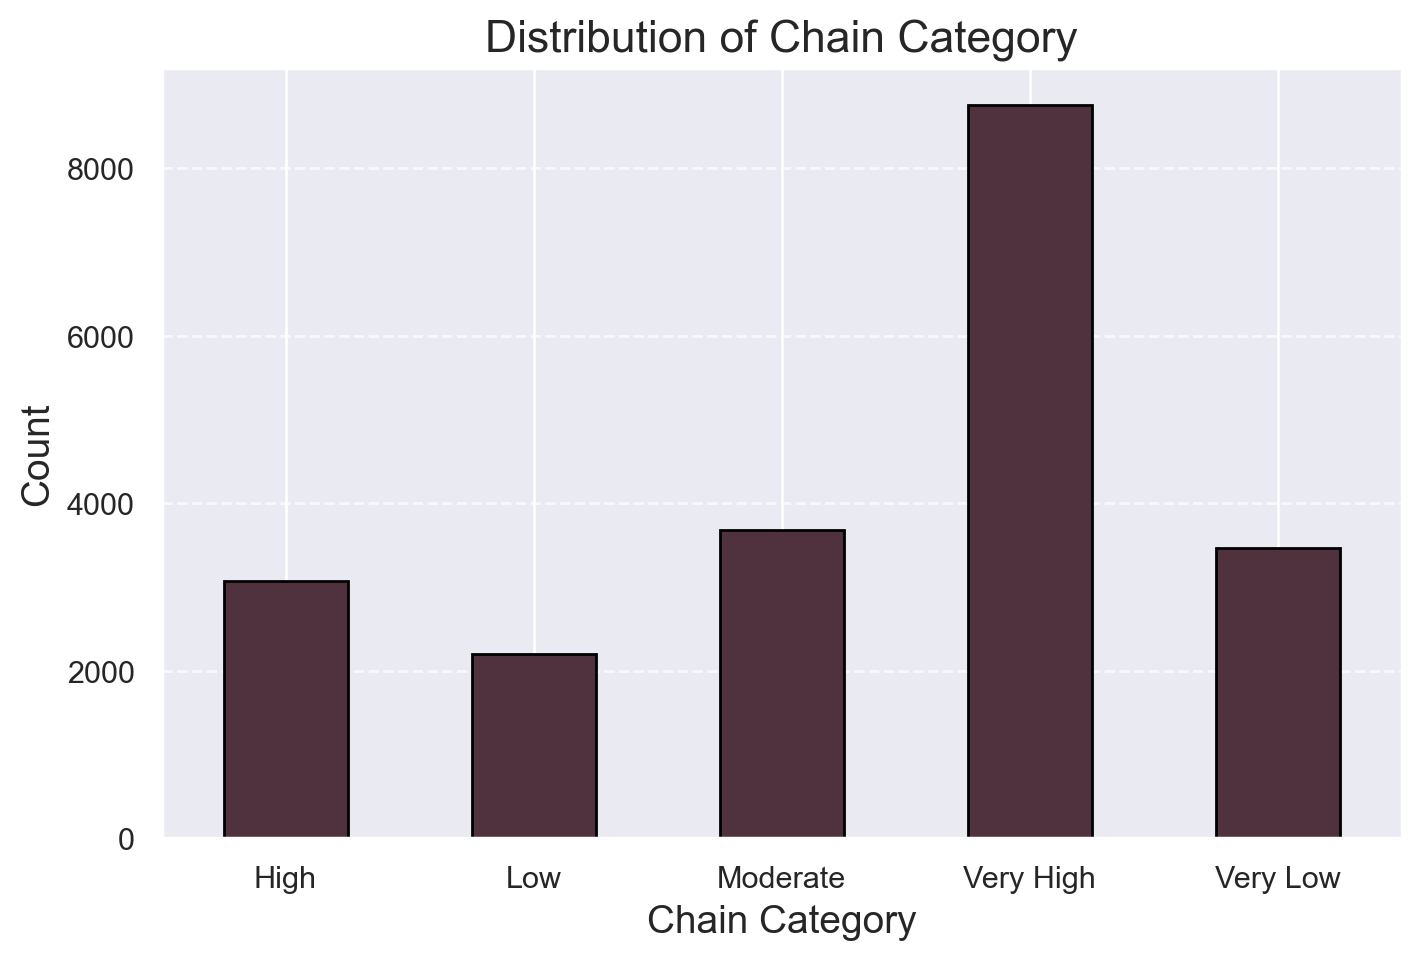

In [108]:
# Count the occurrences of each category
category_counts = food_df['chain_category'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 5))
category_counts.sort_index().plot(kind='bar', color=colors["BR"], edgecolor='black')

# Add title and labels
plt.title('Distribution of Chain Category', fontsize=16)
plt.xlabel('Chain Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()

The chain category with the msot customers, is the "Very High", indicating that a lot of customers by from chain restaurants.

    Average_Days_Between_Orders

> - This feature will help us understand how long frequently a customer places an orders. Even though, this only represents an estimation (for example, we cannot know for sure if the customer placed 3 orders in the same day, or 3 orders 3 days in a row or if they were spaced out more), we believe it can help our analysis.
> - Having a feature that assess frequency is usually beneficial for understanding customer behavior or value.
> - It is calculated by dividing the time a customer is register in our dataset and the total amount of orders place.

In [109]:
food_df['Average_Days_Between_Orders'] = ( food_df['customer_lifetime'] / food_df['total_orders'] )

In [110]:
food_df['Average_Days_Between_Orders'].describe().round(2)

count    21172.00
mean        19.55
std          9.93
min          1.08
25%         11.67
50%         17.50
75%         26.00
max         45.00
Name: Average_Days_Between_Orders, dtype: float64

- 25% of the customers have an averge of 11.67 days between orders
- 50% of the customers have a average of 17.50 days between orders
- 75% of the customers hvae an averge of 26 days between orders

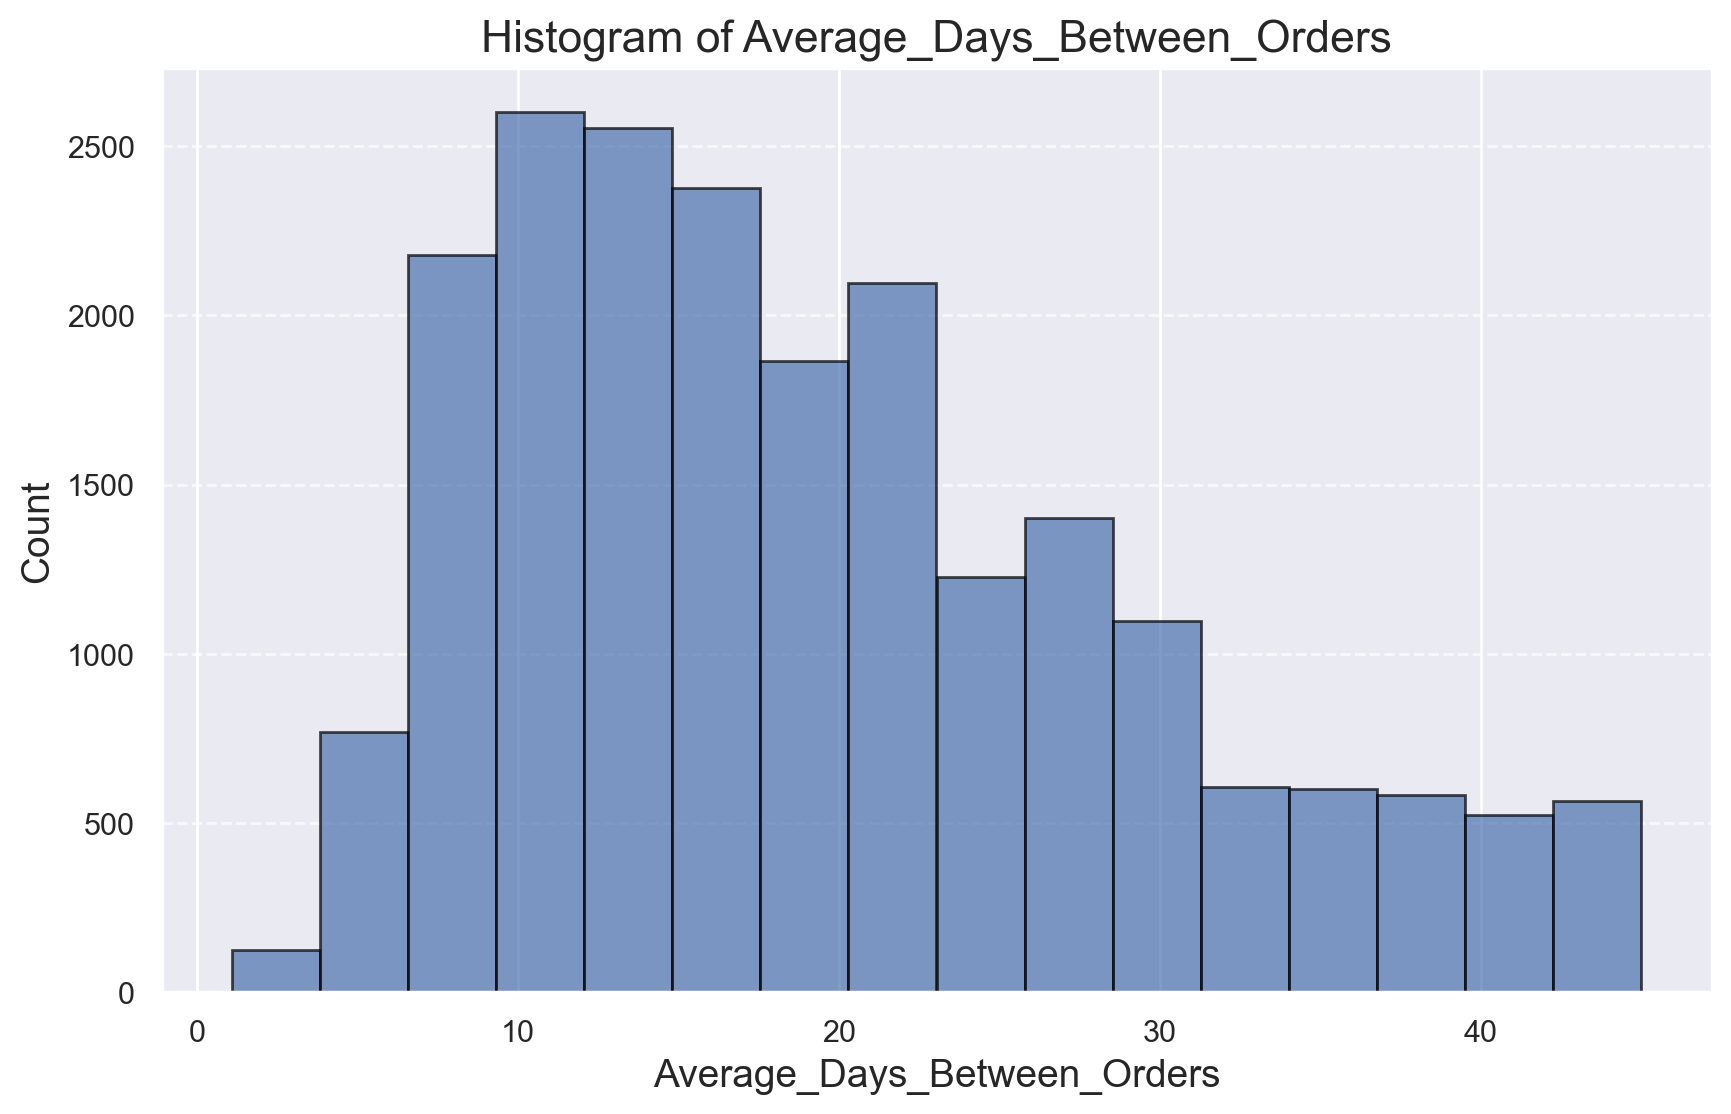

In [111]:
# Now plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(food_df['Average_Days_Between_Orders'], bins= number_bins_sturges(food_df['Average_Days_Between_Orders']), edgecolor='black', alpha=0.7)
plt.title('Histogram of Average_Days_Between_Orders', fontsize=16)
plt.xlabel('Average_Days_Between_Orders', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 6. Feature Reduction

In this step, we will evaluate the relationships between the features to identify any possible correlation between them. This will help reduce any possible redundant feature.

In [112]:
#Dividing the categorical features from the numerical features
food_categorical = food_df.select_dtypes(include=["object", "O"])
food_numerical = food_df.select_dtypes(exclude=["object", "O"]) 

**Cramér's V**

> Measures the association between two categorical variables. We considered Cohen's (2014) values:
>- <0.1 Negligible, 
>- 0.1-0.3 Small, 
>- 0.3-0.5 Medium, 
>- and >0.5 Large

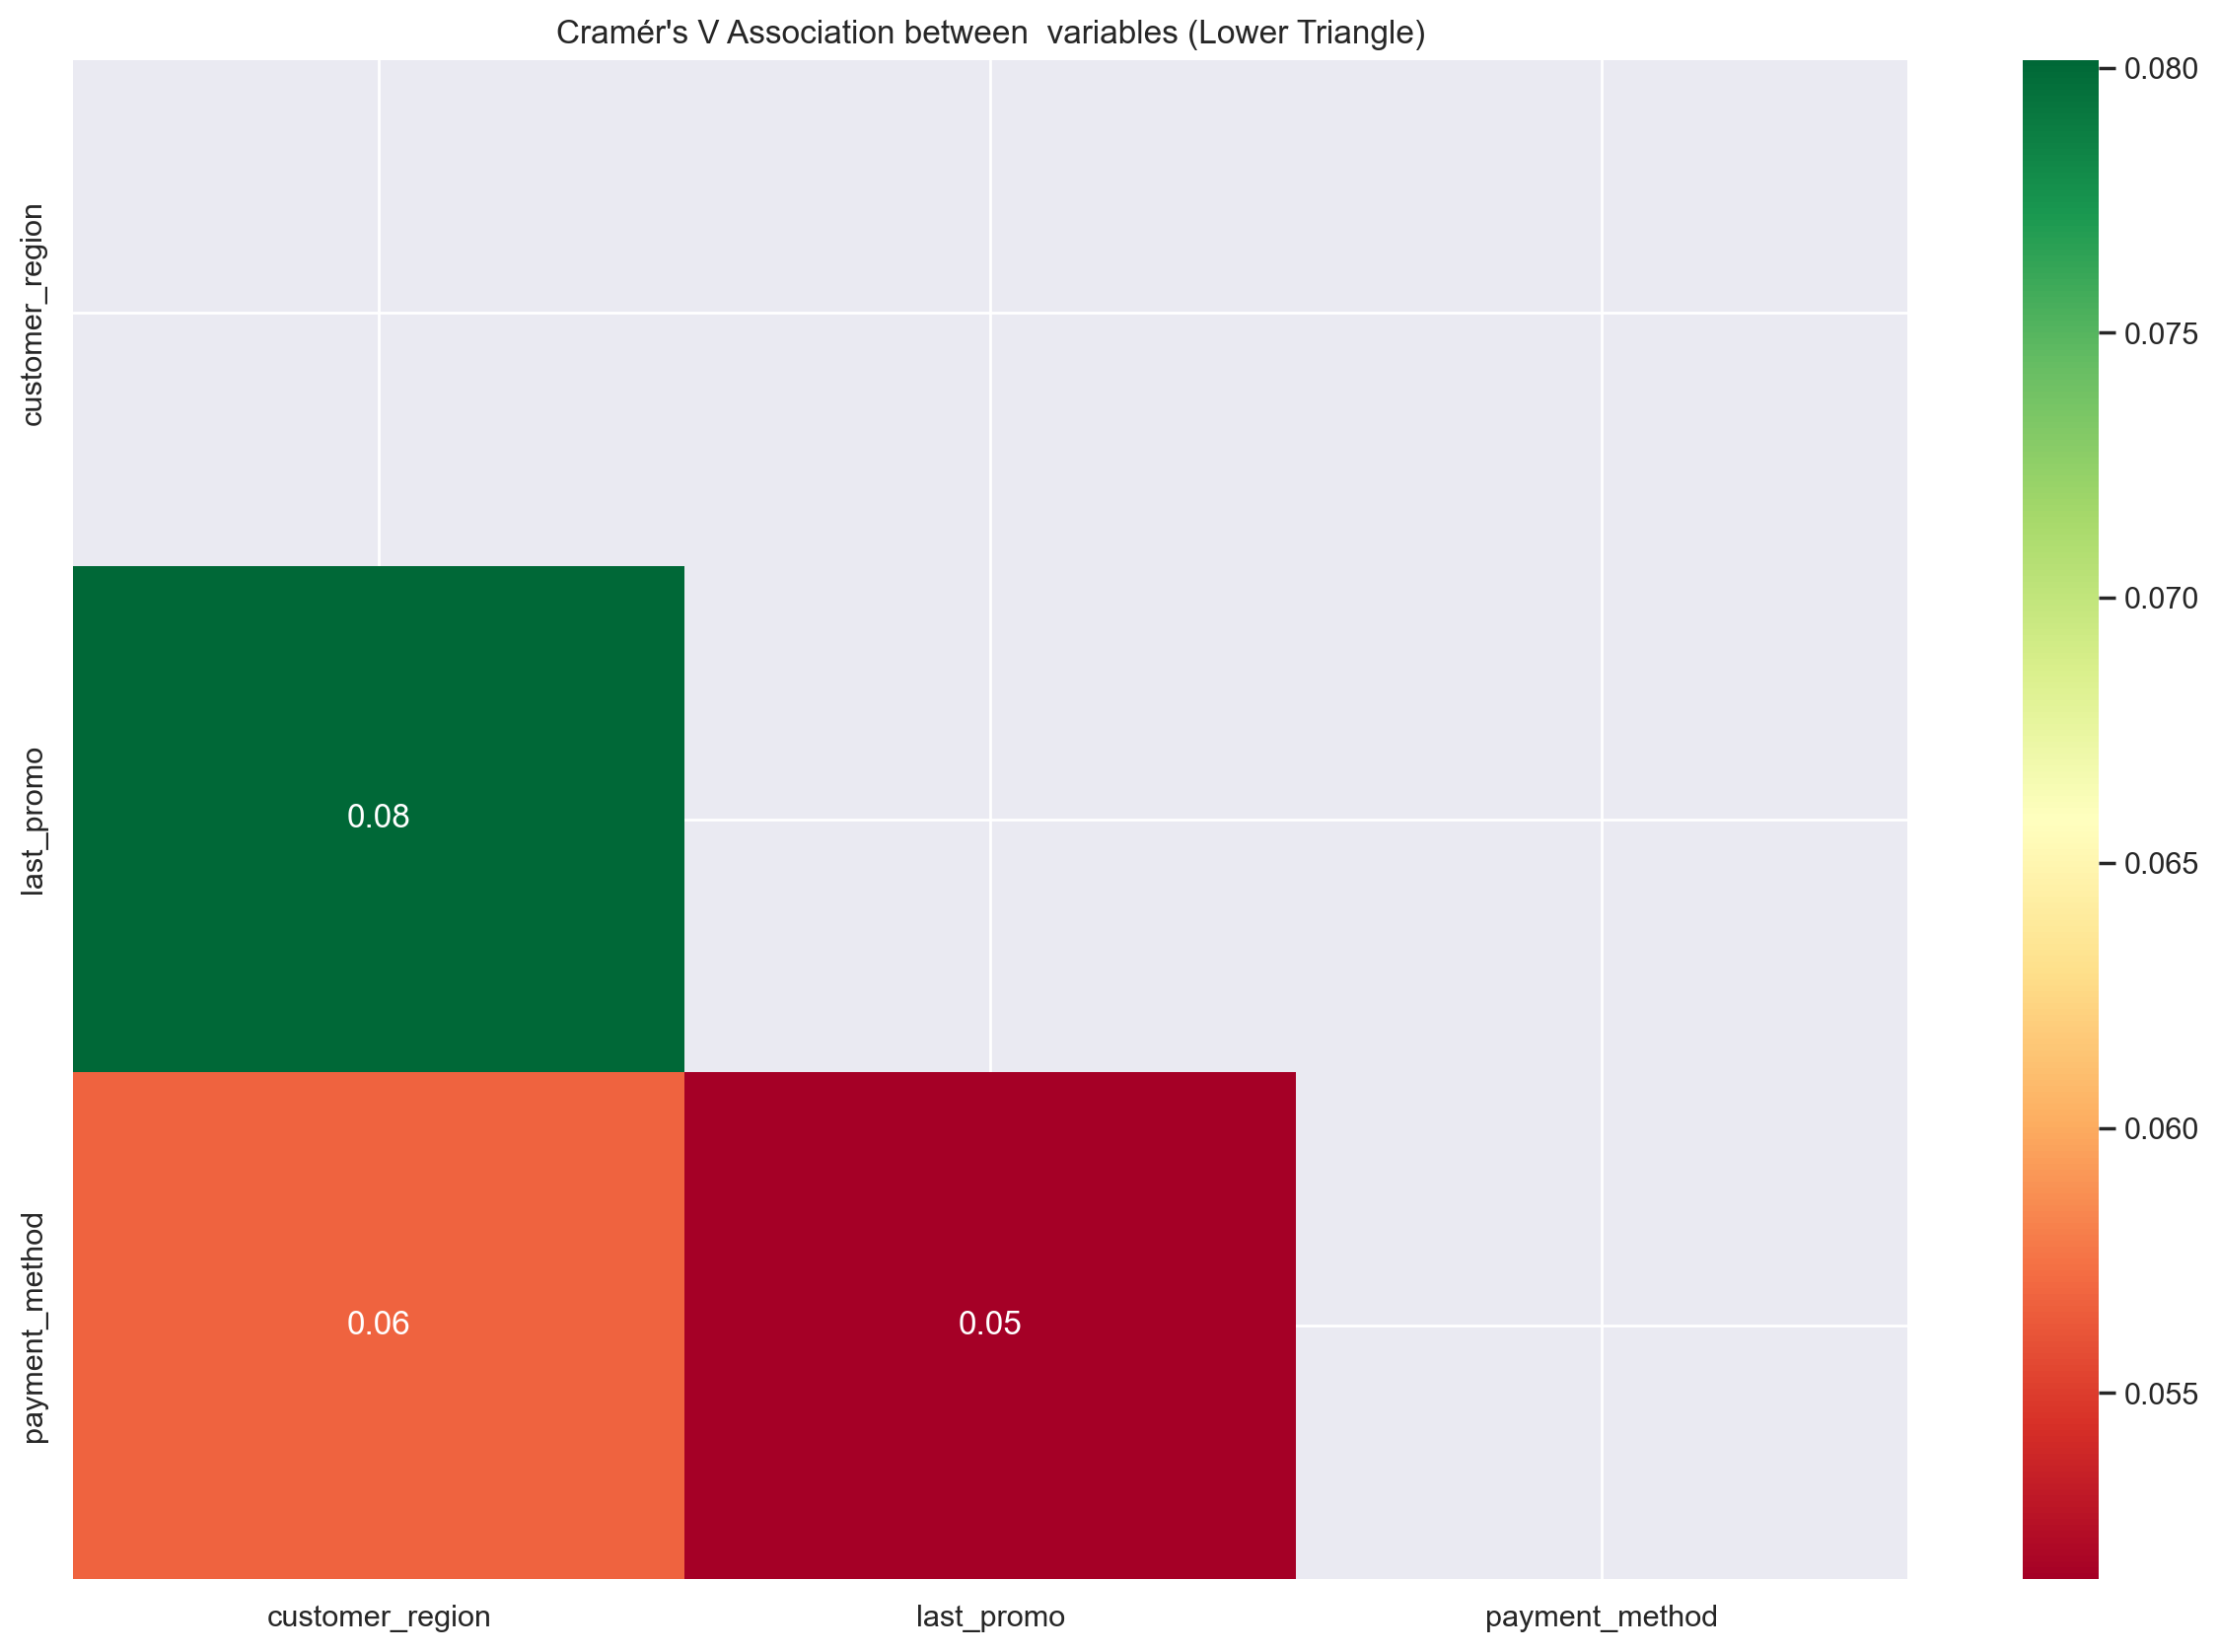

In [113]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

#Selecting the nominal features. Since the Cramer's V cannot be used for ordinal features.
cramers_df = food_categorical[['customer_region','last_promo','payment_method']]
results_cramer = pd.DataFrame(index=cramers_df.columns, columns=cramers_df.columns)

for var1 in cramers_df.columns:
    for var2 in cramers_df.columns:
        if var1 != var2:
            results_cramer.loc[var1, var2] = cramers_v(cramers_df[var1],food_df[var2])
        else:
            results_cramer.loc[var1, var2] = 1  #perfect association with itself

#Heatmap of Cramér's V
results_cramer = results_cramer.astype(float)
mask = np.triu(np.ones_like(results_cramer, dtype=bool))
plt.figure(figsize=(15, 10))
sns.heatmap(results_cramer, annot=True, cmap="RdYlGn", cbar=True, mask=mask, fmt='.2f', linewidths=0, linecolor='white')
plt.title("Cramér's V Association between  variables (Lower Triangle)")
plt.show()

> - We have weak associations between most variables, which means they are likely independent and don't contribute redundant information to the model.
> - We have a moderate association between `chain_category` and `customer_region`, which could indicate some overlap of information. However, we believe this is just telling us that people from a different regions have different preferences about chain restaurants, or about availability or access. So we decided to keep both so far.

**Spearman's Correlation**

> Measures the rank correlation between two variables. We considered the rule of thumb from from Rea and Parker (2014):
>- 0-0.1 Negligible, 
>- 0.1-0.2 Weak, 
>- 0.2-0.4 Moderate, 
>- 0.4-0.6 Relatively Strong, 
>- 0.6-0.8 Strong, 
>- and >=0.8 Very Strong"

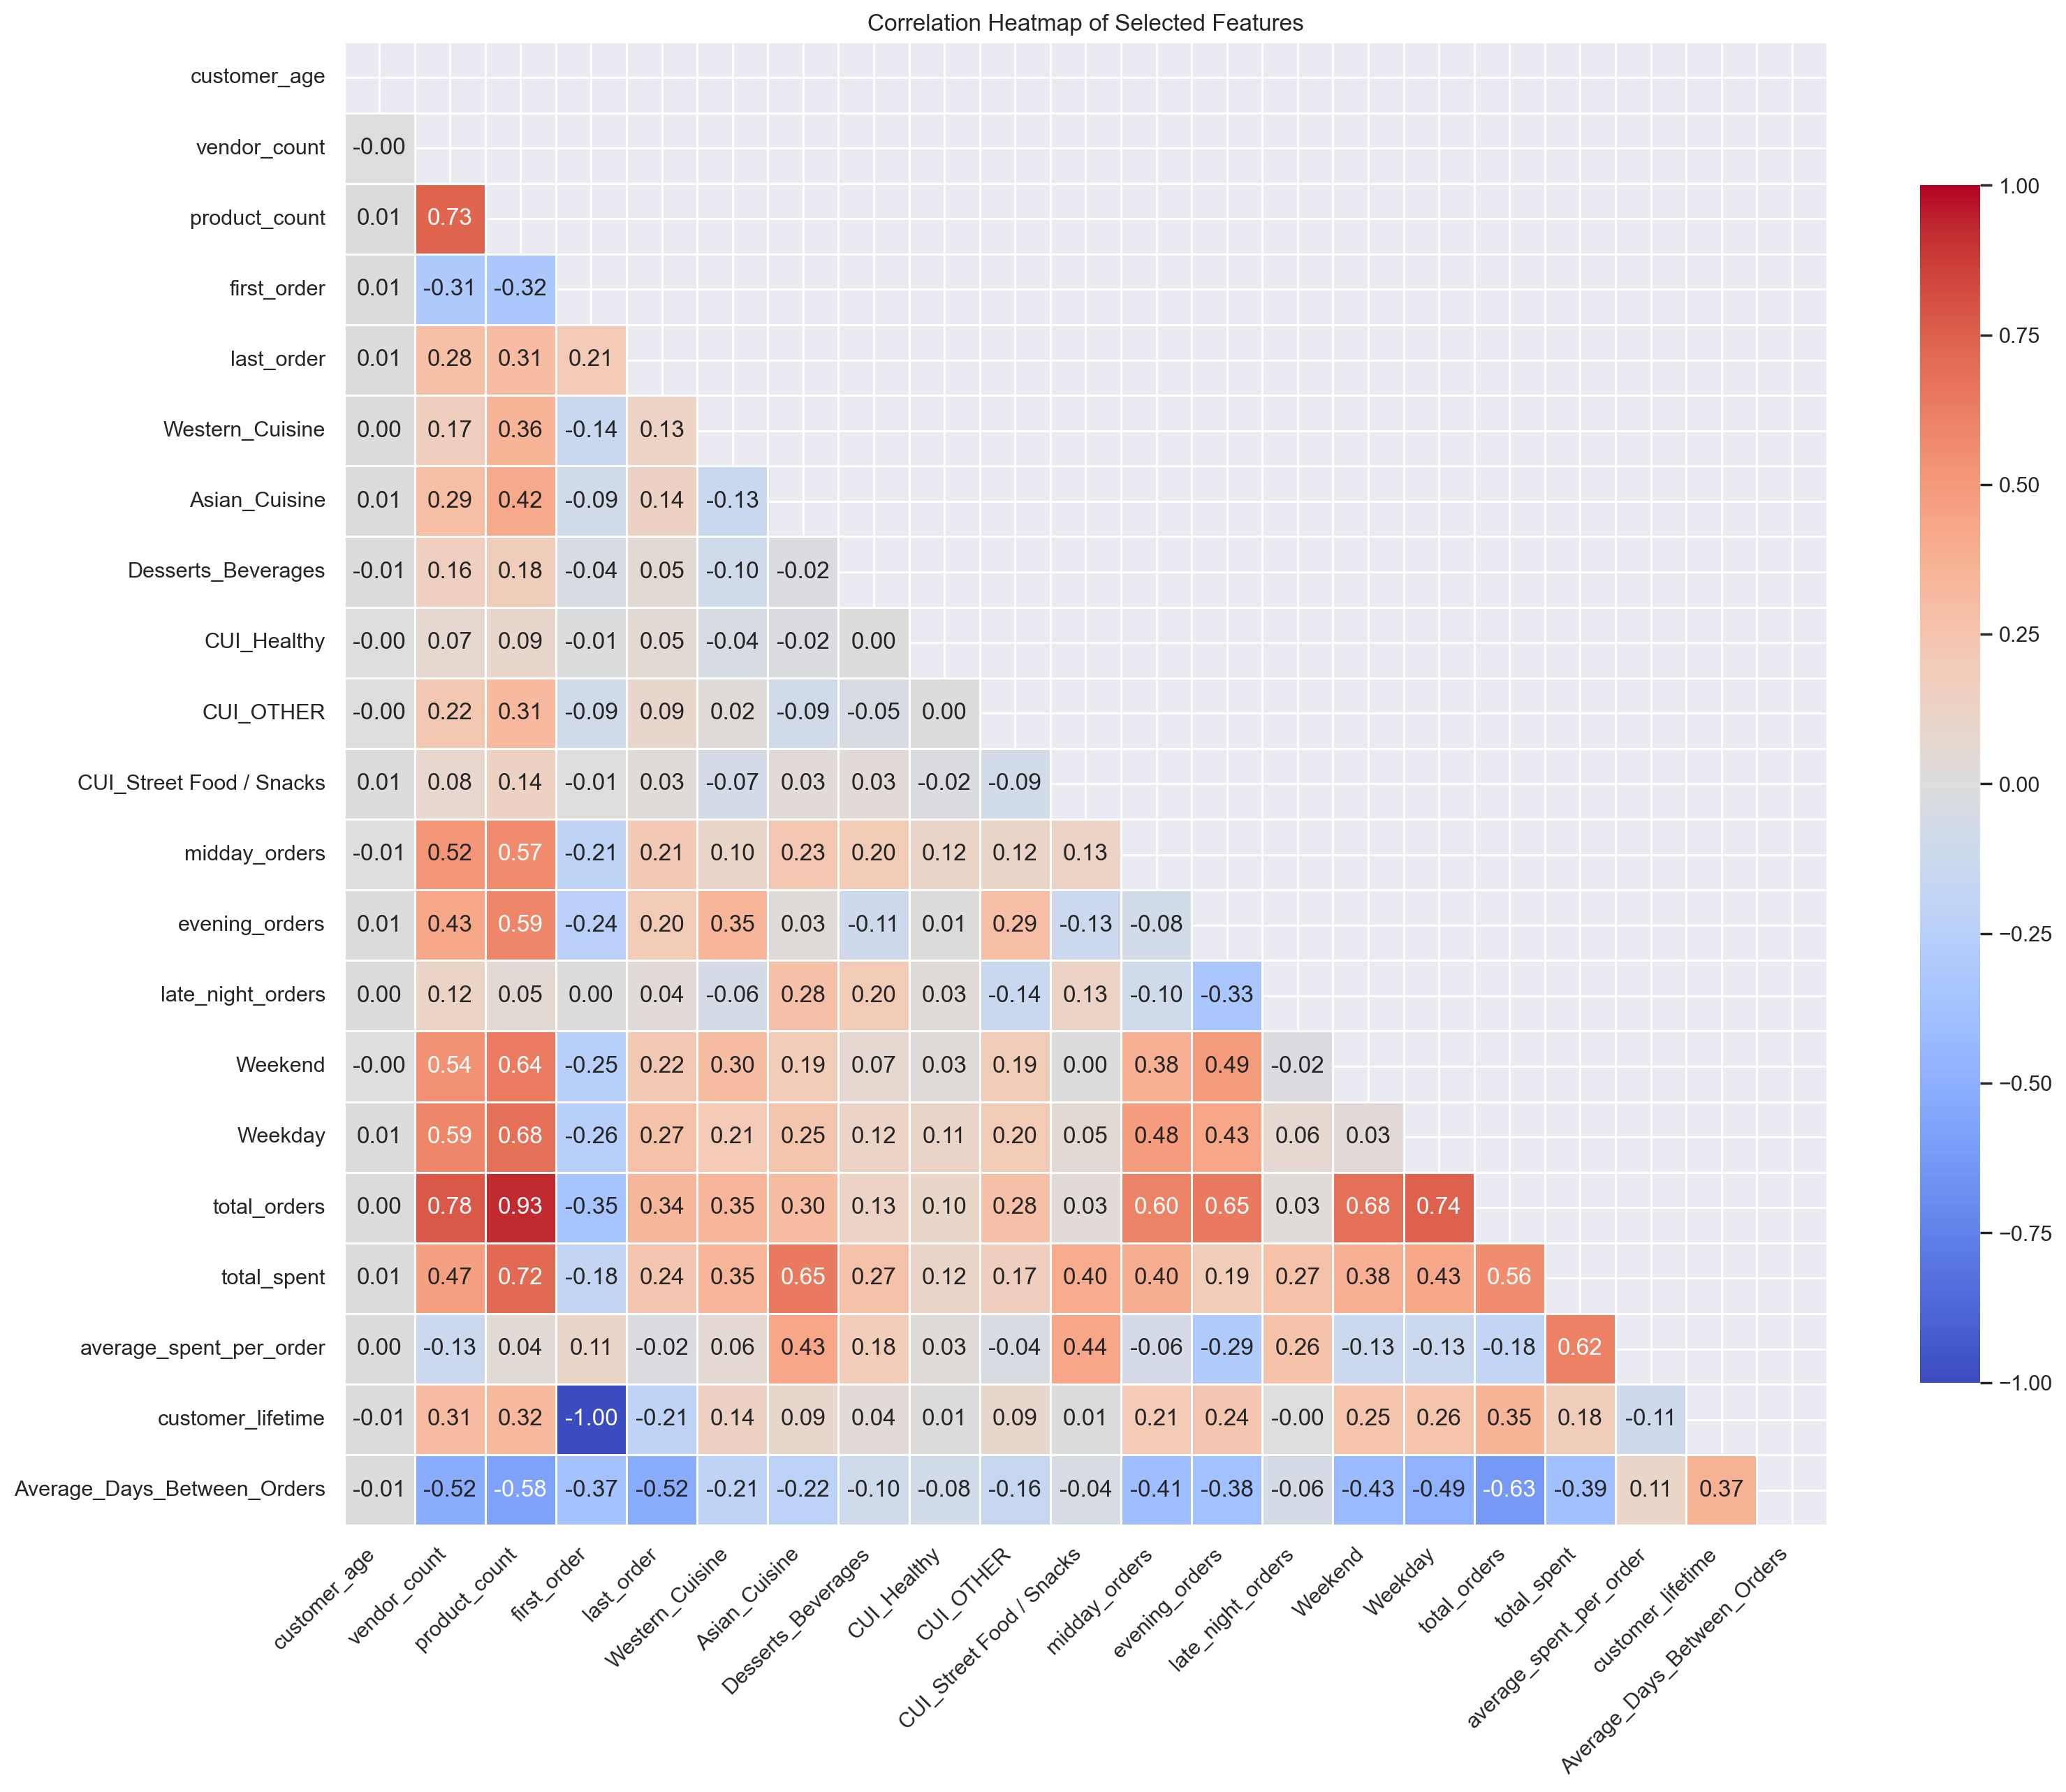

In [114]:
# Calculating the correlation matrix for the selected features
correlation_matrix = food_numerical.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creating the heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation coefficients
            fmt='.2f',   # Format for the annotation
            cmap='coolwarm',  # Color map
            square=True,  # Make cells square
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=0.5,  # Lines between cells
            vmin=-1,  # Minimum limit for color bar
            vmax=1,   # Maximum limit for color bar
            mask=mask)  # Mask the upper triangle

# Set titles and labels
plt.title('Correlation Heatmap of Selected Features')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for readability
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


> - <code>product_count</code> and <code>total_orders</code> have a very high correlation of (0.93=, meaning that they may be giving us the same information and we think total_orders will provide more information. More over it is also highly correlated with <code>vendor_count</code> and the latter will also provide us more information.
> - <code>Weekend</code> and <code>Weekday</code> have a strong correlation with <code>total_orders</code> (~0.7) and <code>product_count</code>.
> - <code>product_count</code> is also strongly correlated with <code>total_spent</code>.
> - <code>vendor_count</code> is highly correlated with <code>product_count</code> and <code>total_orders</code>.
> - The fact that <code>customer_age</code> has no correlation with the other variables, might tell us that demographic segmentation may not be the best fit for this dataset.
> - <code>first_order</code> and <code>last_order</code> have a high correlation with some engineered features and we believe, by themselves, they don't really tell us much.

In [115]:
#Dropping the columns identified above
food_df = food_df.drop(columns=['first_order','last_order','customer_age','product_count'])

In [116]:
#Checking the final features
show_missing(food_df)

,variable,dtype,count,unique,missing
0,customer_region,object,21172,3,0
1,vendor_count,int64,21172,7,0
2,last_promo,object,21172,4,0
3,payment_method,object,21172,3,0
4,Western_Cuisine,float64,21172,3960,0
5,Asian_Cuisine,float64,21172,5354,0
6,Desserts_Beverages,float64,21172,2323,0
7,CUI_Healthy,float64,21172,948,0
8,CUI_OTHER,float64,21172,2198,0
9,CUI_Street Food / Snacks,float64,21172,1836,0


## 7. Feature Transformation

This step was done because, as idenfied in the sections above, the cusine columns have a high percentage of outliers, and as they represent important infomration, we decided to not drop them, and instead, find a way to keep data integrity.


In [117]:
#Getting the cuines columns
CUI_features = ['CUI_Healthy', 'CUI_OTHER','CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']
food_df[CUI_features]

,CUI_Healthy,CUI_OTHER,CUI_Street Food / Snacks,Western_Cuisine,Asian_Cuisine,Desserts_Beverages
customer_id,,,,,,
40b5c1bf89,0.0,5.30,0.0,4.80,0.00,0.00
c79709f885,0.0,3.82,0.0,0.00,21.26,0.00
273bf88a7a,0.0,0.67,0.0,2.92,0.00,1.64
986ffd3978,0.0,0.00,0.0,0.00,24.17,0.00
a9bac03d6b,0.0,0.00,0.0,29.27,0.00,0.00
...,...,...,...,...,...,...
4f85151950,0.0,0.00,0.0,10.35,0.00,0.00
6e531152a9,0.0,0.00,0.0,2.23,4.24,0.00
97a8b1f796,0.0,0.00,0.0,0.00,53.58,0.00


In [118]:
food_df[CUI_features].skew()

CUI_Healthy                 9.624994
CUI_OTHER                   5.063035
CUI_Street Food / Snacks    5.329375
Western_Cuisine             2.958934
Asian_Cuisine               2.148554
Desserts_Beverages          4.721486
dtype: float64

> Normalizing our data is a crucial step. Especially when working with values with very different ranges like numbers of orders and amount spent (monetary values). <br>
> To address this, and also considering the skewness of our data we wanted to apply a transformation to our CUI features to potentially improve clustering approaches. <br>

__**CUI Distributions**__

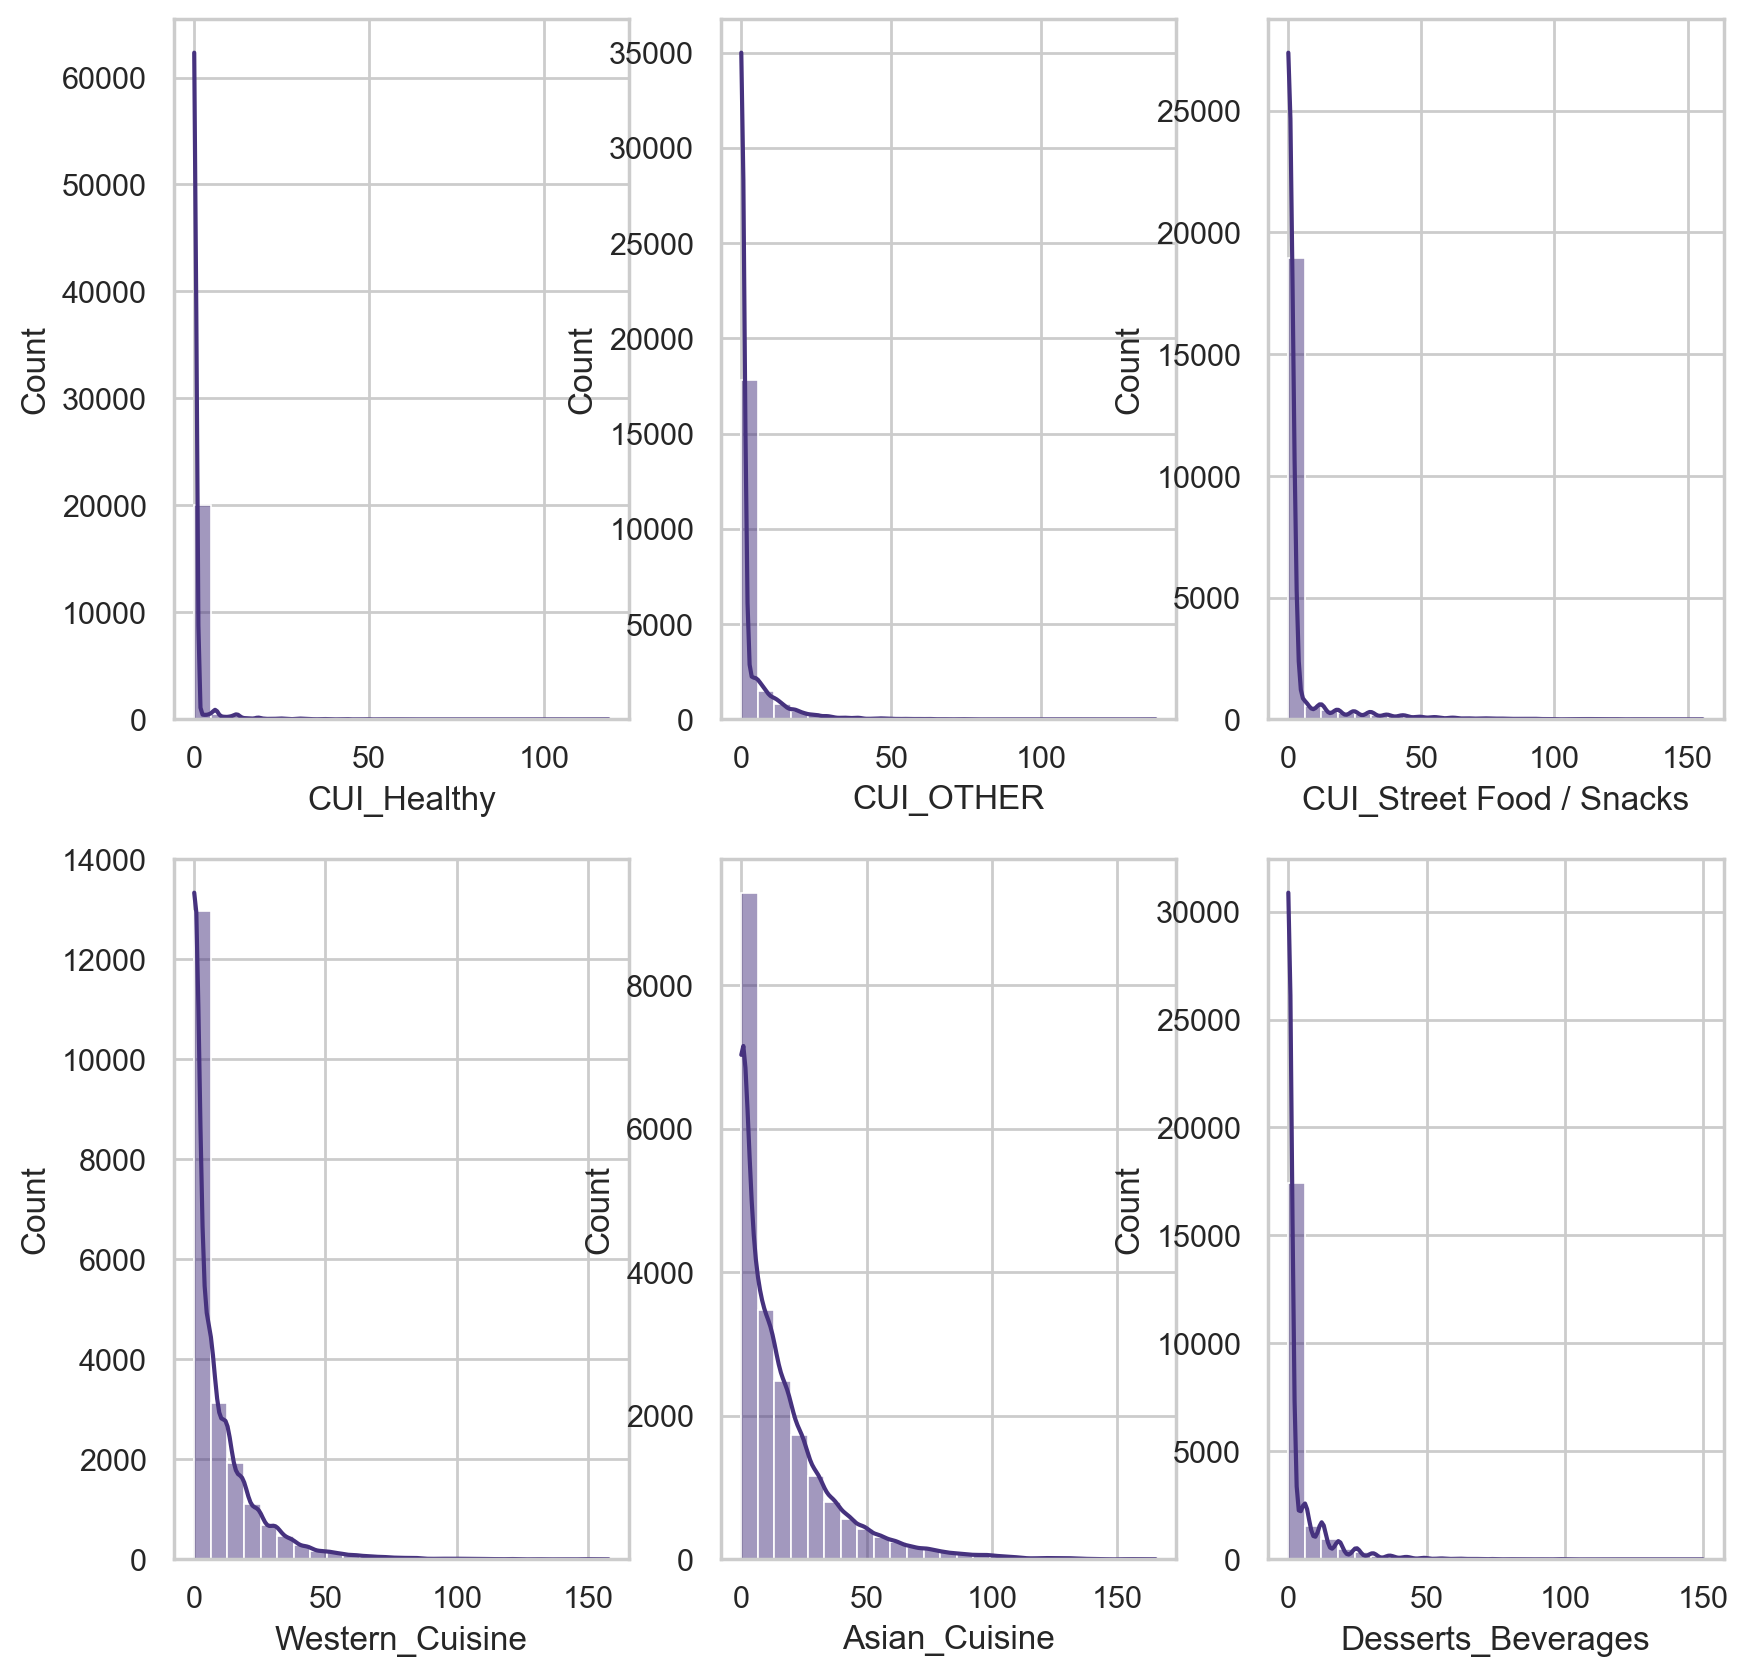

In [119]:
CUI_features = ['CUI_Healthy', 'CUI_OTHER','CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']
sns.set(style="whitegrid", palette="viridis")

fig, axes = plt.subplots(2, 3, figsize=(10, 10))

for ax, feat in zip(axes.flatten(), CUI_features): 
    sns.histplot(food_df[feat],bins=25, kde=True , legend=False, ax = ax)

We can observe that the cuisine columns are very right skewed, which can give us problems when doing the clusters, hence we are going to transform them.

- The `Yeo-Johnson` transformation is an extension of the Box-Cox transformation, designed to handle both positive and negative values in the dataset. Similar to Box-Cox, the Yeo-Johnson transformation aims to stabilize variance, make the data more symmetric, and bring it closer to a normal distribution. The formula is:

    Yeo-Johnson Transformation Formula

For a given value \(x\) and transformation parameter \(\lambda\):

1. For \(x \geq 0\):
\[
T(x; \lambda) =
\begin{cases} 
\frac{(x + 1)^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\log(x + 1), & \text{if } \lambda = 0
\end{cases}
\]

2. For \(x < 0\):
\[
T(x; \lambda) =
\begin{cases} 
-\frac{(-x + 1)^{2 - \lambda} - 1}{2 - \lambda}, & \text{if } \lambda \neq 2 \\
-\log(-x + 1), & \text{if } \lambda = 2
\end{cases}
\]


`source`: https://medium.com/@vinodkumargr/09-data-transformations-in-ml-different-transformations-in-machine-learning-log-transformer-d794d61d143d 

In [120]:

#Making sure the cusiine columns are positive
for column in CUI_features:
    if (food_df[column] <= 0).any():
        food_df[column] += abs(food_df[column].min()) + 1e-6

#Applying the Johnson transformation using PowerTransforomer
pt = PowerTransformer(method='yeo-johnson', standardize=True)  # 'yeo-johnson' lida com valores positivos e negativos
johnson_transformed = pt.fit_transform(food_df[CUI_features])

#Converting the trasnfomed data back to the dataframe
johnson_df = pd.DataFrame(johnson_transformed, columns=CUI_features, index=food_df.index)

food_df[CUI_features] = johnson_df[CUI_features]
food_df[CUI_features]

,CUI_Healthy,CUI_OTHER,CUI_Street Food / Snacks,Western_Cuisine,Asian_Cuisine,Desserts_Beverages
customer_id,,,,,,
40b5c1bf89,-0.278896,1.780232,-0.3883,0.375343,-1.315987,-0.594694
c79709f885,-0.278896,1.714521,-0.3883,-1.061212,0.741447,-0.594694
273bf88a7a,-0.278896,0.842128,-0.3883,0.091631,-1.315987,1.204202
986ffd3978,-0.278896,-0.561507,-0.3883,-1.061212,0.837511,-0.594694
a9bac03d6b,-0.278896,-0.561507,-0.3883,1.382548,-1.315987,-0.594694
...,...,...,...,...,...,...
4f85151950,-0.278896,-0.561507,-0.3883,0.819295,-1.315987,-0.594694
6e531152a9,-0.278896,-0.561507,-0.3883,-0.055782,-0.301152,-0.594694
97a8b1f796,-0.278896,-0.561507,-0.3883,-1.061212,1.472029,-0.594694


Checking the distribution after the transformation

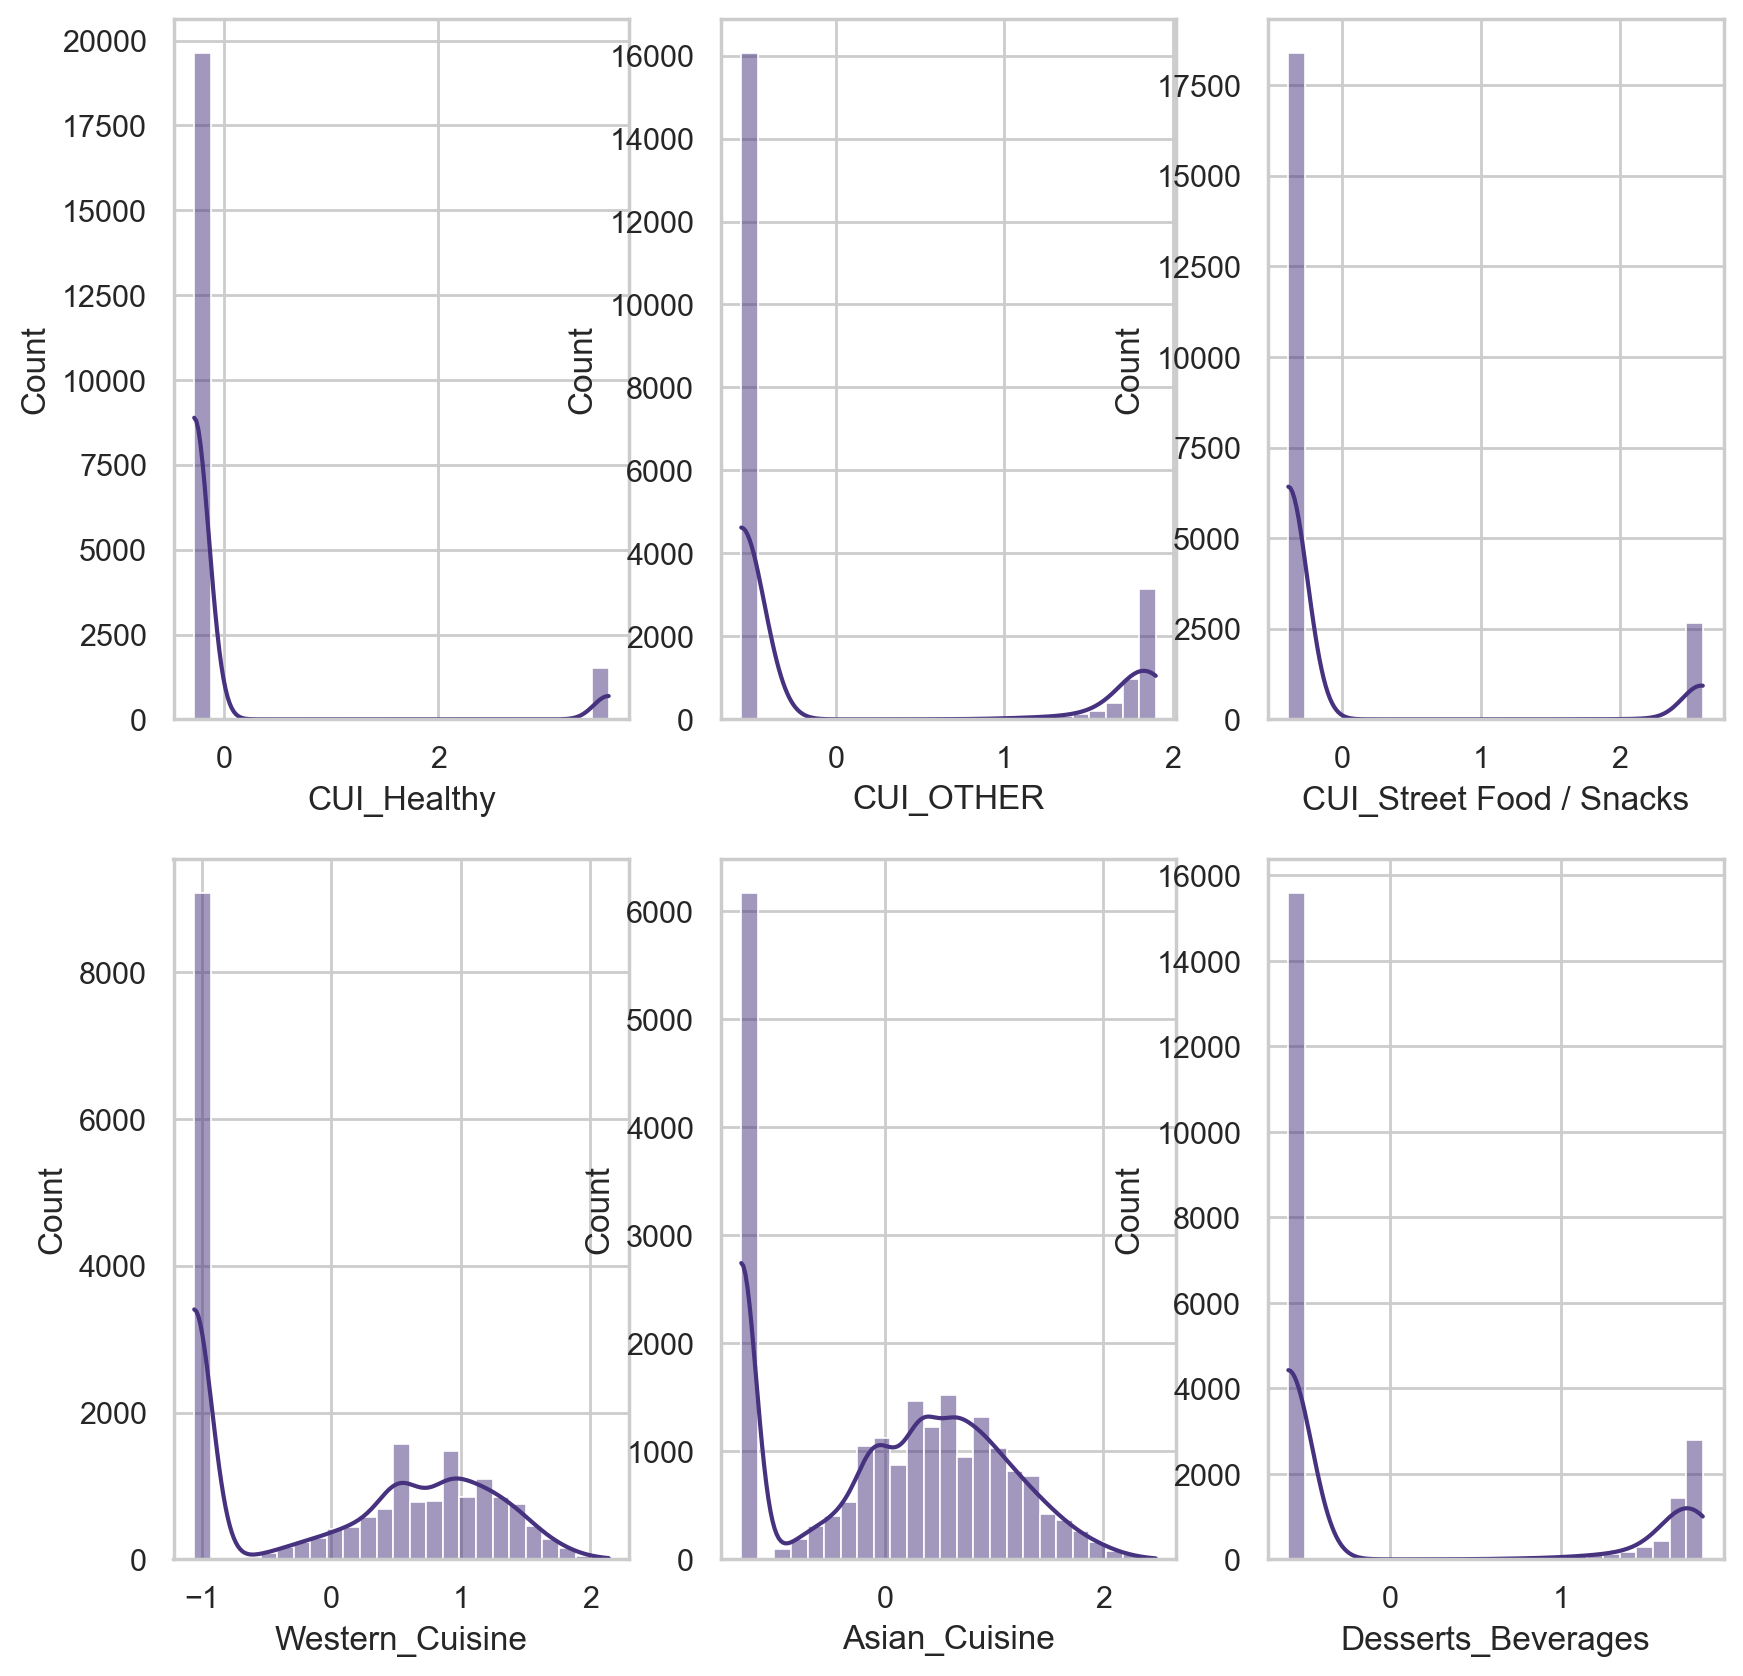

In [121]:
CUI_features = ['CUI_Healthy', 'CUI_OTHER','CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']
sns.set(style="whitegrid", palette="viridis")

fig, axes = plt.subplots(2, 3, figsize=(10, 10))

for ax, feat in zip(axes.flatten(), CUI_features): # Notice the zip() function and flatten() method
    sns.histplot(food_df[feat],bins=25, kde=True , legend=False, ax = ax)

We can observe that after the transformation, some cuisnie columns present a more bell-shaped distribution, and that the distribution of the columns is less skewed.

# Data Exporting

In [122]:
#Exporting the dataset
food_df.to_csv('../Data/food_df_preprocessed.csv', index=False) 